In [1]:
import psycopg2
from psycopg2 import sql
import numpy as np
import pandas as pd
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine, text
import getpass
from scipy.stats import ttest_ind, zscore
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from itertools import combinations
from itertools import product
import geopandas as gpd
from shapely import wkt

In [ ]:
mypasswd = getpass.getpass("Enter your database password: ")
username = 'jsmm8'
host = 'pgsql'
database = 'f24t03'

conn_string = f"postgresql+psycopg2://{username}:{mypasswd}@{host}/{database}"
engine = create_engine(conn_string)

Enter your database password: ········


In [ ]:
#Create the connection and extract data from 'race_data_processed' table
try:
    conn = psycopg2.connect(database=database,
                            user='jsmm8',
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the race_data_processed table
query = "SELECT * FROM springfield_final_dataset;"

# Use pandas to read the SQL query into a DataFrame
try:
    df = gpd.read_postgis(query, conn, geom_col='home_geolocation')
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()

I am able to connect to the database
Data extracted successfully!


In [4]:
df.head()

,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,occupancy_consistency,housing_chg_20_22,occupancy_chg_20_22,pct_value_chg_20_22,house_price,bedrooms,bathrooms,square_footage,lot_size,year_built
0,POINT (478828.036 4106430.367),1500000US290770040021,2840 E TARA CT,109976,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,368495.199053,5,4,1706,17855.0,1983
1,POINT (478863.082 4106437.207),1500000US290770040021,2846 E TARA CT,109977,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,333961.627714,5,3,1173,18280.0,2009
2,POINT (478890.412 4106437.067),1500000US290770040021,2852 E TARA CT,107290,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,358686.215774,5,5,3367,15016.0,1991
3,POINT (478920.588 4106437.843),1500000US290770040021,2856 E TARA CT,55192,65804,ZONE4,C,R-SF,1.23,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,346362.075920,3,2,2481,15586.0,2000
4,POINT (478953.800 4106446.339),1500000US290770040021,5920 S BELGRAVIA AVE,88558,65804,ZONE4,C,R-SF,1.23,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,359821.771482,2,5,1627,21441.0,1974


In [5]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43388 entries, 0 to 43387
Data columns (total 89 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   home_geolocation                            43388 non-null  geometry
 1   block_group_id                              43388 non-null  object  
 2   address                                     43388 non-null  object  
 3   objectid                                    43388 non-null  int64   
 4   zip5                                        43388 non-null  int64   
 5   nsa                                         43388 non-null  object  
 6   bds_zone                                    43388 non-null  object  
 7   zoning                                      43388 non-null  object  
 8   drive_time_fire                             43376 non-null  float64 
 9   drive_distance_fire                         43376 non-null  floa

In [6]:
print(df.columns)

Index(['home_geolocation', 'block_group_id', 'address', 'objectid', 'zip5',
       'nsa', 'bds_zone', 'zoning', 'drive_time_fire', 'drive_distance_fire',
       'feature_geolocation_fire', 'feature_address_fire',
       'feature_category_fire', 'drive_time_police', 'drive_distance_police',
       'feature_geolocation_police', 'feature_address_police',
       'feature_category_police', 'drive_time_early_childhood_school',
       'drive_distance_early_childhood_school',
       'feature_geolocation_early_childhood_school',
       'feature_address_early_childhood_school',
       'feature_category_early_childhood_school',
       'drive_time_elementary_school', 'drive_distance_elementary_school',
       'feature_geolocation_elementary_school',
       'feature_address_elementary_school',
       'feature_category_elementary_school', 'drive_time_middle_school',
       'drive_distance_middle_school', 'feature_geolocation_middle_school',
       'feature_address_middle_school', 'feature_category_m

# Summary Statistics

In [7]:
# Compute summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
objectid,43388.0,56929.943394,29514.684246,1813.00,31194.750000,59166.500000,80590.250000,124482.000000
zip5,43388.0,65804.354038,2.108838,65802.00,65803.000000,65804.000000,65807.000000,65810.000000
drive_time_fire,43376.0,3.805306,1.628475,0.00,2.790000,3.660000,4.680000,11.410000
drive_distance_fire,43376.0,1.391839,0.650076,0.00,0.960000,1.320000,1.760000,4.350000
drive_time_police,43376.0,5.811133,2.835427,0.00,3.550000,5.100000,8.030000,15.750000
drive_distance_police,43376.0,2.258402,1.379668,0.00,1.220000,1.810000,3.080000,8.900000
drive_time_early_childhood_school,43376.0,9.421858,4.301555,0.00,6.580000,9.100000,12.020000,22.210000
drive_distance_early_childhood_school,43376.0,3.759283,1.964396,0.00,2.490000,3.460000,4.920000,10.590000
drive_time_elementary_school,43376.0,2.438493,1.537945,0.00,1.370000,2.120000,3.120000,11.800000
drive_distance_elementary_school,43376.0,0.820362,0.602361,0.00,0.420000,0.680000,1.040000,6.140000


# Accessibility Per Single Family Houses

### Drive Time to Places

A summary of average drive times and distances to key services by neighborhood (NSA). You can quickly spot which neighborhoods have better or worse proximity to essential services like schools, hospitals, police, etc.

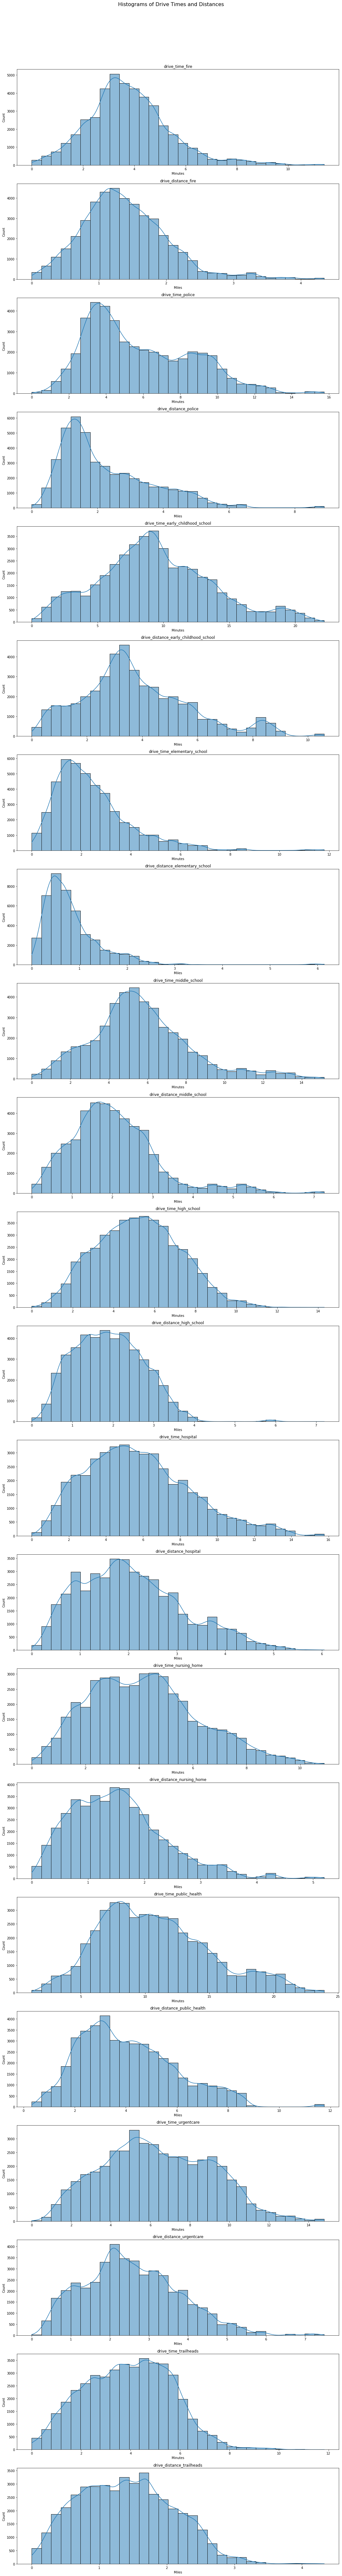

In [8]:
# Set up drive time and distance columns for all features
drive_cols = [col for col in df.columns if col.startswith('drive_time_') or col.startswith('drive_distance_')]

# Plot histograms of drive times and drive distances
fig, axs = plt.subplots(len(drive_cols), figsize=(15, 5 * len(drive_cols)))
fig.suptitle("Histograms of Drive Times and Distances", fontsize=16, y=1.02)

for i, col in enumerate(drive_cols):
    sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axs[i])
    axs[i].set_title(f"{col}")
    axs[i].set_xlabel("Minutes" if "time" in col else "Miles")

plt.tight_layout()
plt.show()

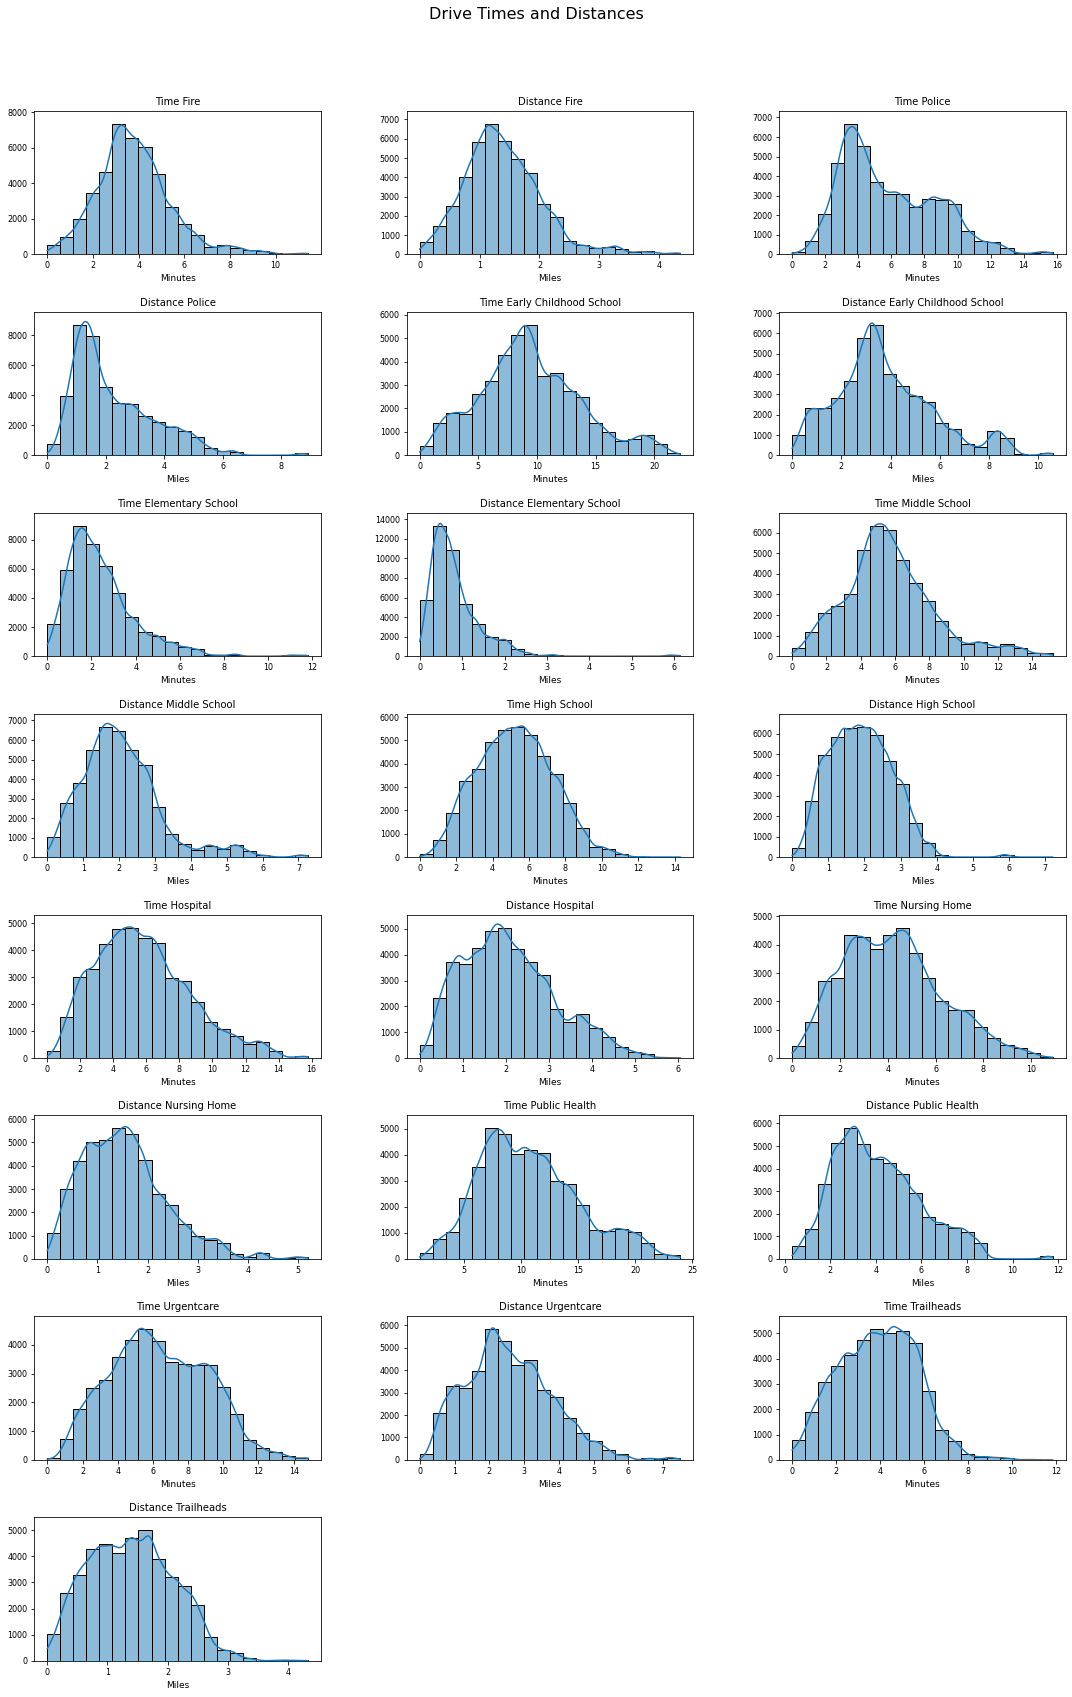

In [9]:
# Set up drive time and distance columns for all features
drive_cols = [col for col in df.columns if col.startswith('drive_time_') or col.startswith('drive_distance_')]

# Calculate the grid dimensions for small multiples
import math
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(len(drive_cols) / n_cols)

# Create small multiples plot
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
fig.suptitle("Drive Times and Distances", fontsize=16, y=0.98)

# Flatten the axes array for easier indexing
axs = axs.flatten() if n_rows > 1 else [axs] if n_cols == 1 else axs

# Plot each histogram in the grid
for i, col in enumerate(drive_cols):
    if i < len(axs):  # Check to prevent index errors
        sns.histplot(df[col].dropna(), bins=20, kde=True, ax=axs[i])
        axs[i].set_title(f"{col.replace('drive_', '').replace('_', ' ').title()}", fontsize=10)
        axs[i].set_xlabel("Minutes" if "time" in col else "Miles", fontsize=9)
        axs[i].tick_params(axis='both', labelsize=8)
        
        # Remove y-axis label to save space
        axs[i].set_ylabel("")
        
        # Tight y-limits to focus on data
        counts, bins = np.histogram(df[col].dropna(), bins=20)
        if max(counts) > 0:  # Ensure there is data
            axs[i].set_ylim(0, max(counts) * 1.1)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)
plt.show()

# Accessibility per Neighborhood

### Neighborhood Drive Summary

Heatmaps showing the average drive times and drive distances by neighborhood for fire stations, police stations, elementary schools, and hospitals.

### Average Drive Time to key services by Neighborhood

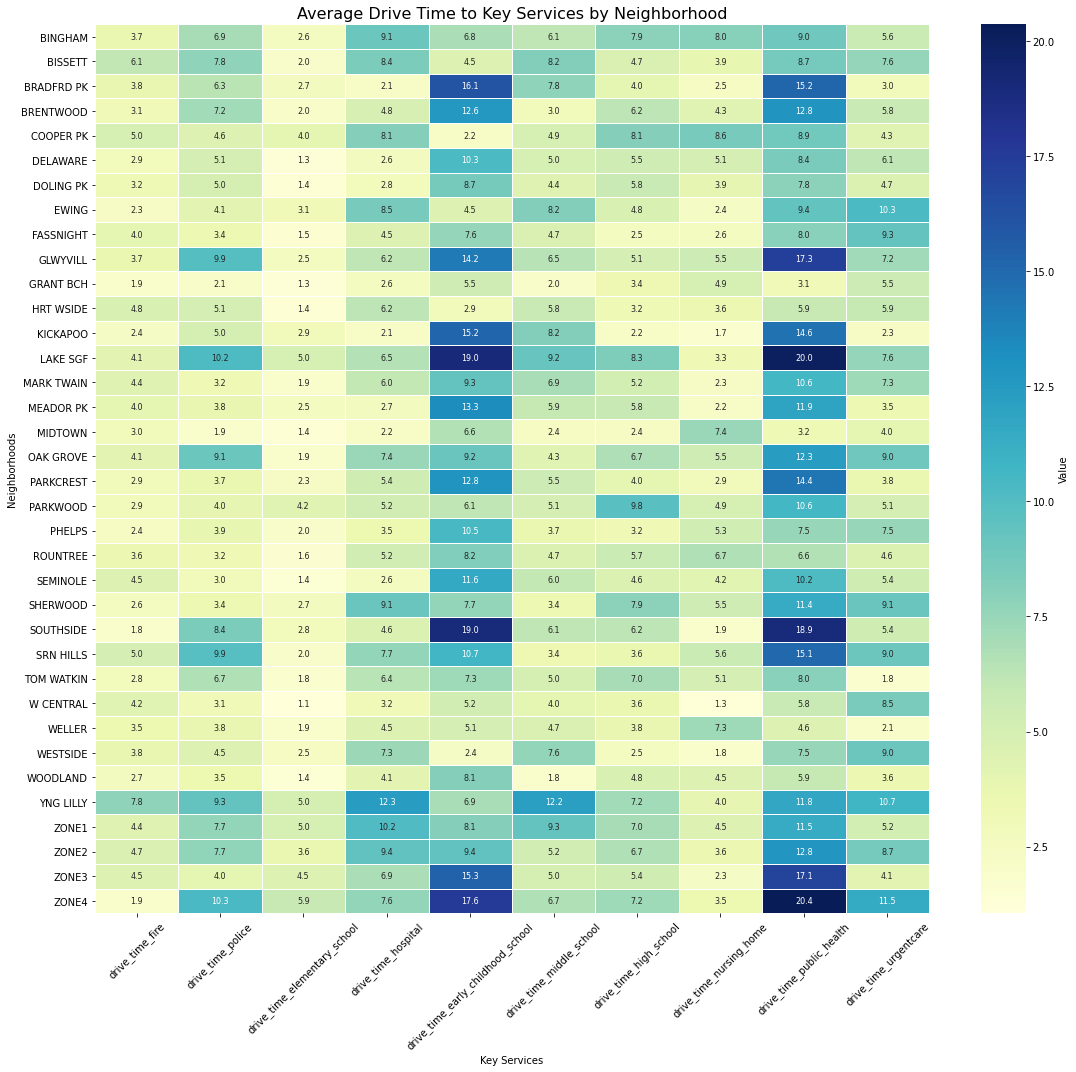

In [10]:
neighborhood_summary = df.groupby("nsa")[drive_cols].median().sort_index()

# Drive Time features
time_features = [
    'drive_time_fire', 'drive_time_police', 
    'drive_time_elementary_school', 'drive_time_hospital',
    'drive_time_early_childhood_school',
    'drive_time_middle_school','drive_time_high_school',
    'drive_time_nursing_home', 'drive_time_public_health',
    'drive_time_urgentcare'
]

# Create Drive Time Heatmap
plt.figure(figsize=(16, 15))

sns.heatmap(
    neighborhood_summary[time_features], 
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=.5,
    cbar_kws={'label': 'Value'},
    annot_kws={"size": 8}
)

plt.title("Average Drive Time to Key Services by Neighborhood", fontsize=16)
plt.xlabel("Key Services")
plt.ylabel("Neighborhoods")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Top & Bottom Neighborhoods by Service

Identify which neighborhoods are best or worst served in terms of access to: Fire & police stations, Schools, and Hospitals

In [11]:
# Define drive time columns
drive_cols = [
    'drive_time_fire', 'drive_time_police', 
    'drive_time_elementary_school', 'drive_time_hospital',
    'drive_time_early_childhood_school',
    'drive_time_middle_school', 'drive_time_high_school',
    'drive_time_nursing_home', 'drive_time_public_health',
    'drive_time_urgentcare'
]

# Compute summary stats across all NSAs
summary_stats = df[drive_cols].agg(['min', 'max', 'mean', 'median', 'std']).T

# Optional: Round for readability
summary_stats = summary_stats.round(2)

# Display the result
print("Summary Statistics for Drive Time Features:")
print(summary_stats)

Summary Statistics for Drive Time Features:
                                    min    max   mean  median   std
drive_time_fire                    0.00  11.41   3.81    3.66  1.63
drive_time_police                  0.00  15.75   5.81    5.10  2.84
drive_time_elementary_school       0.00  11.80   2.44    2.12  1.54
drive_time_hospital                0.00  15.77   5.79    5.46  2.85
drive_time_early_childhood_school  0.00  22.21   9.42    9.10  4.30
drive_time_middle_school           0.00  15.17   5.68    5.43  2.59
drive_time_high_school             0.00  14.30   5.24    5.21  2.04
drive_time_nursing_home            0.00  10.90   4.21    4.07  2.05
drive_time_public_health           1.17  23.95  10.76   10.27  4.33
drive_time_urgentcare              0.00  14.80   6.37    6.18  2.72


##  Summary stats per NSA

In [12]:
# Summary stats per NSA (mean or median)
per_nsa_stats = df.groupby('nsa')[drive_cols].agg(['min', 'max', 'mean', 'median', 'std']).round(2)
per_nsa_stats

drive_time_fire                           drive_time_police         \
                       min    max  mean median   std               min    max   
nsa                                                                             
BINGHAM               1.80   7.06  3.97   3.68  1.25              3.95  10.32   
BISSETT               4.65   7.50  6.08   6.10  0.41              5.57   9.43   
BRADFRD PK            2.74   4.66  3.77   3.80  0.46              5.09   7.28   
BRENTWOOD             0.00   5.14  2.98   3.06  1.03              4.77   9.41   
COOPER PK             1.78   6.31  4.50   4.97  1.20              3.02   7.26   
DELAWARE              1.15   3.61  2.79   2.86  0.54              3.01   6.69   
DOLING PK             0.00   5.54  2.99   3.20  1.05              2.67   6.83   
EWING                 1.01   3.27  2.29   2.30  0.67              2.80   4.75   
FASSNIGHT             2.05   5.42  3.91   4.02  0.73              0.00   4.86   
GLWYVILL              0.00   7.44  3.66   3.69  1.57              6.16  14.88   
GRANT BCH             0.00   3.44  1.93   1.87  0.70              0.69   3.81   
HRT WSIDE             2.98   6.77  4.74   4.79  0.76              3.27   7.03   
KICKAPOO              0.54   4.47  2.56   2.39  0.95              2.90   7.36   
LAKE SGF              1.97   7.69  4.20   4.07  0.96              7.76  13.22   
MARK TWAIN            1.66   5.85  4.36   4.40  0.73              1.05   4.57   
MEADOR PK             1.47   5.45  3.85   4.05  0.85              1.14   7.03   
MIDTOWN               1.40   3.80  2.90   3.00  0.63              0.00   3.19   
OAK GROVE             0.00   6.41  4.00   4.08  1.15              4.96  10.21   
PARKCREST             0.49   5.00  2.93   2.94  0.96              1.79   5.49   
PARKWOOD              1.04   4.20  2.66   2.90  0.68              2.60   4.76   
PHELPS                0.27   4.18  2.34   2.41  0.98              1.95   5.31   
ROUNTREE              2.19   4.58  3.48   3.57  0.56              1.43   4.86   
SEMINOLE              2.80   5.71  4.42   4.46  0.62              0.00   5.15   
SHERWOOD              0.79   3.43  2.64   2.56  0.60              1.55   4.29   
SOUTHSIDE             0.00   4.46  2.20   1.84  1.15              6.99  10.47   
SRN HILLS             1.32   7.28  4.77   5.05  1.47              7.93  11.91   
TOM WATKIN            0.37   4.24  2.72   2.82  0.90              5.05   8.07   
W CENTRAL             1.81   4.99  4.09   4.23  0.67              1.65   3.75   
WELLER                2.25   4.63  3.51   3.50  0.60              2.06   5.33   
WESTSIDE              1.31   5.96  3.75   3.79  0.89              2.04   7.39   
WOODLAND              0.72   3.97  2.61   2.71  0.67              1.54   5.60   
YNG LILLY             5.02  11.41  7.77   7.80  1.37              6.51  12.90   
ZONE1                 0.00   8.07  3.90   4.44  2.35              2.65  10.06   
ZONE2                 0.00   9.60  4.68   4.69  1.76              0.88  12.44   
ZONE3                 1.35   5.67  4.16   4.52  1.15              0.24   6.10   
ZONE4                 0.00   8.07  2.77   1.85  2.41              4.75  15.75   

                                ... drive_time_public_health                \
             mean median   std  ...                      min    max   mean   
nsa                             ...                                          
BINGHAM      7.14   6.94  1.42  ...                     6.52  13.29   9.42   
BISSETT      7.79   7.82  0.96  ...                     6.28  10.37   8.58   
BRADFRD PK   6.29   6.27  0.54  ...                    14.04  16.23  15.22   
BRENTWOOD    7.19   7.16  1.03  ...                    10.01  15.78  13.03   
COOPER PK    4.99   4.58  1.14  ...                     7.01  10.53   8.94   
DELAWARE     5.07   5.09  0.86  ...                     6.44  10.19   8.43   
DOLING PK    4.94   5.02  0.85  ...                     6.16  10.09   7.93   
EWING        4.04   4.10  0.48  ...                     8.01   9.97   9

### Neighborhood with Fastest and slowest Service Access

In [13]:
# Drive time columns
drive_cols = [
    'drive_time_fire', 'drive_time_police', 'drive_time_elementary_school',
    'drive_time_hospital', 'drive_time_early_childhood_school',
    'drive_time_middle_school', 'drive_time_high_school',
    'drive_time_nursing_home', 'drive_time_public_health',
    'drive_time_urgentcare'
]

# Initialize the summary dictionary
summary = {}

# Loop through each column
for col in drive_cols:
    # Filter out zeroes
    non_zero = df[df[col] > 0]
    fastest = non_zero[col].idxmin()
    slowest = df[col].idxmax()

    summary[col] = {
        'Fastest': (df.loc[fastest, 'nsa'], round(df.loc[fastest, col], 2)),
        'Slowest': (df.loc[slowest, 'nsa'], round(df.loc[slowest, col], 2))
    }

# 💬 Print the final clean summary
for feature, data in summary.items():
    label = feature.replace('drive_time_', '').replace('_', ' ').title()
    print(f"{label} Access")
    print(f"Fastest: {data['Fastest'][0]} ({data['Fastest'][1]} min)")
    print(f"Slowest: {data['Slowest'][0]} ({data['Slowest'][1]} min)\n")

Fire Access
Fastest: BRENTWOOD (0.02 min)
Slowest: YNG LILLY (11.41 min)

Police Access
Fastest: ZONE3 (0.24 min)
Slowest: ZONE4 (15.75 min)

Elementary School Access
Fastest: BINGHAM (0.11 min)
Slowest: ZONE4 (11.8 min)

Hospital Access
Fastest: ZONE4 (0.13 min)
Slowest: YNG LILLY (15.77 min)

Early Childhood School Access
Fastest: WESTSIDE (0.2 min)
Slowest: LAKE SGF (22.21 min)

Middle School Access
Fastest: WOODLAND (0.05 min)
Slowest: YNG LILLY (15.17 min)

High School Access
Fastest: WESTSIDE (0.26 min)
Slowest: ZONE2 (14.3 min)

Nursing Home Access
Fastest: MEADOR PK (0.07 min)
Slowest: ZONE4 (10.9 min)

Public Health Access
Fastest: MIDTOWN (1.17 min)
Slowest: ZONE4 (23.95 min)

Urgentcare Access
Fastest: TOM WATKIN (0.12 min)
Slowest: ZONE4 (14.8 min)



### Compare Best vs. Worst Performing NSAs

In [14]:
# Print the full matrix
neighborhood_summary[time_features]

# Optionally, highlight important rows/columns
high_values = neighborhood_summary[time_features][neighborhood_summary[time_features].max(axis=1) > 15]
high_values

,drive_time_fire,drive_time_police,drive_time_elementary_school,drive_time_hospital,drive_time_early_childhood_school,drive_time_middle_school,drive_time_high_school,drive_time_nursing_home,drive_time_public_health,drive_time_urgentcare
nsa,,,,,,,,,,
BRADFRD PK,3.80,6.27,2.69,2.14,16.13,7.84,4.05,2.46,15.21,3.01
GLWYVILL,3.69,9.90,2.51,6.16,14.19,6.48,5.08,5.54,17.29,7.20
KICKAPOO,2.39,4.98,2.87,2.11,15.16,8.21,2.20,1.73,14.62,2.26
LAKE SGF,4.07,10.22,4.95,6.51,19.02,9.25,8.30,3.26,20.04,7.61
SOUTHSIDE,1.84,8.38,2.82,4.61,19.01,6.14,6.25,1.87,18.94,5.39
SRN HILLS,5.05,9.86,2.03,7.69,10.67,3.36,3.64,5.62,15.05,9.04
ZONE3,4.52,4.02,4.51,6.86,15.32,5.01,5.40,2.34,17.10,4.11
ZONE4,1.85,10.34,5.87,7.64,17.59,6.65,7.24,3.52,20.37,11.48


In [15]:
# Highlight important rows/columns
low_values = neighborhood_summary[time_features][neighborhood_summary[time_features].max(axis=1) < 8]
low_values

,drive_time_fire,drive_time_police,drive_time_elementary_school,drive_time_hospital,drive_time_early_childhood_school,drive_time_middle_school,drive_time_high_school,drive_time_nursing_home,drive_time_public_health,drive_time_urgentcare
nsa,,,,,,,,,,
GRANT BCH,1.87,2.09,1.33,2.63,5.48,2.05,3.36,4.94,3.07,5.54
HRT WSIDE,4.79,5.07,1.37,6.20,2.91,5.79,3.17,3.56,5.87,5.93
MIDTOWN,3.00,1.88,1.37,2.16,6.61,2.43,2.43,7.39,3.20,4.01
TOM WATKIN,2.82,6.69,1.78,6.38,7.28,5.00,7.01,5.06,7.97,1.79
WELLER,3.50,3.77,1.91,4.55,5.09,4.69,3.80,7.31,4.59,2.09


In [16]:
# Define the accessibility index columns for each category
healthcare_cols = [
    'drive_time_hospital', 'drive_time_nursing_home', 'drive_time_public_health'
]
education_cols = [
    'drive_time_early_childhood_school', 'drive_time_elementary_school',
    'drive_time_middle_school', 'drive_time_high_school'
]
emergency_cols = [
    'drive_time_fire', 'drive_time_police'
]

# Compute average indices by NSA
nsa_accessibility = df.groupby("nsa")[healthcare_cols + education_cols + emergency_cols].median()

# Create category-specific accessibility indices (lower is better)
nsa_accessibility['Healthcare_Index'] = nsa_accessibility[healthcare_cols].mean(axis=1)
nsa_accessibility['Education_Index'] = nsa_accessibility[education_cols].mean(axis=1)
nsa_accessibility['Emergency_Index'] = nsa_accessibility[emergency_cols].mean(axis=1)

# Function to categorize into quintiles
def categorize_index(series):
    return pd.qcut(series, q=5, labels=["Low", "Low-Medium", "Medium", "Medium-High", "High"])

# Apply categorization
nsa_accessibility['Healthcare_Category'] = categorize_index(nsa_accessibility['Healthcare_Index'])
nsa_accessibility['Education_Category'] = categorize_index(nsa_accessibility['Education_Index'])
nsa_accessibility['Emergency_Category'] = categorize_index(nsa_accessibility['Emergency_Index'])

# Prepare results for display
categorized_access = nsa_accessibility[[
    'Healthcare_Index', 'Healthcare_Category',
    'Education_Index', 'Education_Category',
    'Emergency_Index', 'Emergency_Category'
]].reset_index()

categorized_access

,nsa,Healthcare_Index,Healthcare_Category,Education_Index,Education_Category,Emergency_Index,Emergency_Category
0,BINGHAM,8.693333,Medium-High,5.8525,Medium,5.3100,Medium-High
1,BISSETT,6.983333,Medium,4.8375,Low-Medium,6.9600,High
2,BRADFRD PK,6.603333,Medium,7.6775,High,5.0350,Medium-High
3,BRENTWOOD,7.305000,Medium,5.9625,Medium-High,5.1100,Medium-High
4,COOPER PK,8.503333,Medium-High,4.7950,Low-Medium,4.7750,Medium
5,DELAWARE,5.386667,Low,5.5125,Medium,3.9750,Medium
6,DOLING PK,4.855000,Low,5.0450,Low-Medium,4.1100,Medium
7,EWING,6.760000,Medium,5.1250,Low-Medium,3.2000,Low
8,FASSNIGHT,5.010000,Low,4.0700,Low,3.7050,Low-Medium
9,GLWYVILL,9.663333,High,7.0650,Medium-High,6.7950,High


In [17]:
# Prepare sorted data for individual plots
healthcare_sorted = categorized_access.sort_values("Healthcare_Index")
education_sorted = categorized_access.sort_values("Education_Index")
emergency_sorted = categorized_access.sort_values("Emergency_Index")

# Store sorted data for use in separate cells
print(healthcare_sorted[['nsa', 'Healthcare_Index', 'Healthcare_Category']])

           nsa  Healthcare_Index Healthcare_Category
27   W CENTRAL          3.400000                 Low
10   GRANT BCH          3.546667                 Low
16     MIDTOWN          4.250000                 Low
30    WOODLAND          4.843333                 Low
6    DOLING PK          4.855000                 Low
8    FASSNIGHT          5.010000                 Low
11   HRT WSIDE          5.210000                 Low
5     DELAWARE          5.386667                 Low
20      PHELPS          5.423333          Low-Medium
28      WELLER          5.483333          Low-Medium
29    WESTSIDE          5.540000          Low-Medium
15   MEADOR PK          5.606667          Low-Medium
22    SEMINOLE          5.683333          Low-Medium
12    KICKAPOO          6.153333          Low-Medium
21    ROUNTREE          6.180000          Low-Medium
14  MARK TWAIN          6.306667              Medium
26  TOM WATKIN          6.470000              Medium
2   BRADFRD PK          6.603333              

In [18]:
print(education_sorted[['nsa', 'Education_Index', 'Education_Category']])

           nsa  Education_Index Education_Category
10   GRANT BCH           3.0550                Low
16     MIDTOWN           3.2100                Low
11   HRT WSIDE           3.3100                Low
27   W CENTRAL           3.4725                Low
29    WESTSIDE           3.7550                Low
28      WELLER           3.8725                Low
30    WOODLAND           4.0275                Low
8    FASSNIGHT           4.0700                Low
4    COOPER PK           4.7950         Low-Medium
1      BISSETT           4.8375         Low-Medium
20      PHELPS           4.8650         Low-Medium
25   SRN HILLS           4.9250         Low-Medium
21    ROUNTREE           5.0425         Low-Medium
6    DOLING PK           5.0450         Low-Medium
7        EWING           5.1250         Low-Medium
26  TOM WATKIN           5.2675             Medium
23    SHERWOOD           5.4100             Medium
5     DELAWARE           5.5125             Medium
17   OAK GROVE           5.5425

In [19]:
print(emergency_sorted[['nsa', 'Emergency_Index', 'Emergency_Category']])

           nsa  Emergency_Index Emergency_Category
10   GRANT BCH           1.9800                Low
16     MIDTOWN           2.4400                Low
23    SHERWOOD           3.0000                Low
30    WOODLAND           3.1150                Low
20      PHELPS           3.1400                Low
7        EWING           3.2000                Low
18   PARKCREST           3.3050                Low
21    ROUNTREE           3.4100                Low
19    PARKWOOD           3.4400         Low-Medium
28      WELLER           3.6350         Low-Medium
27   W CENTRAL           3.6800         Low-Medium
12    KICKAPOO           3.6850         Low-Medium
8    FASSNIGHT           3.7050         Low-Medium
22    SEMINOLE           3.7275         Low-Medium
14  MARK TWAIN           3.8250         Low-Medium
15   MEADOR PK           3.9350             Medium
5     DELAWARE           3.9750             Medium
6    DOLING PK           4.1100             Medium
29    WESTSIDE           4.1450

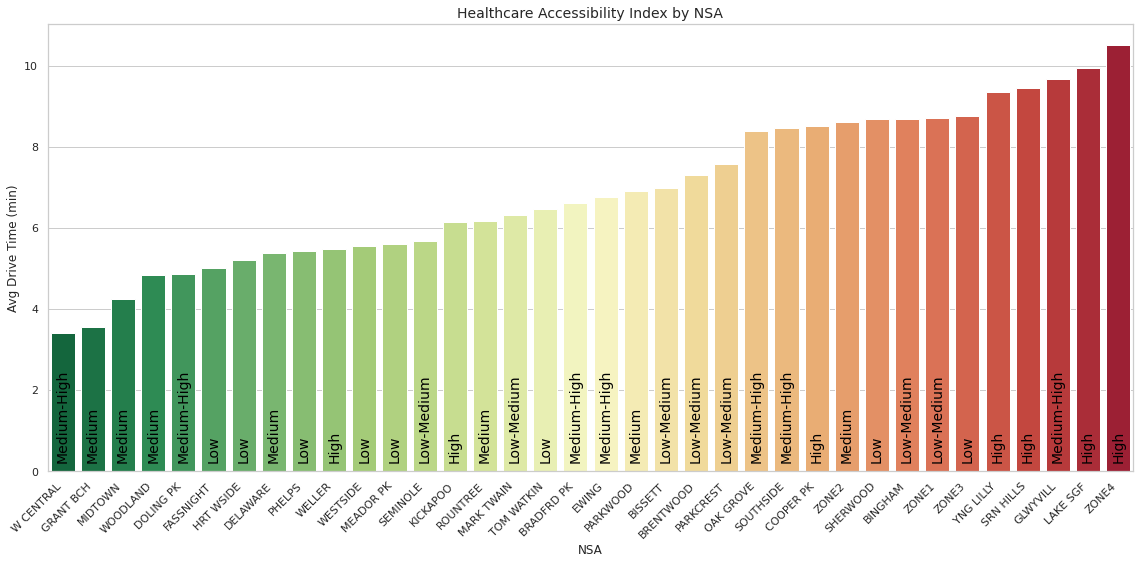

In [20]:
# Set style for clean layout
sns.set(style="whitegrid")

# Plot with cleaner spacing and labels
plt.figure(figsize=(16, 8))
barplot = sns.barplot(
    data=healthcare_sorted,
    x='nsa',
    y='Healthcare_Index',
    palette='RdYlGn_r'
)

# Title and labels
plt.title("Healthcare Accessibility Index by NSA", fontsize=14)
plt.ylabel("Avg Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Add category label at the base of each bar
for index, row in healthcare_sorted.iterrows():
    barplot.text(
        index, 
        0.2,
        row['Healthcare_Category'],
        color='black',
        ha='center',
        va='bottom',
        fontsize=14,
        rotation=90
    )

plt.tight_layout()
plt.show()

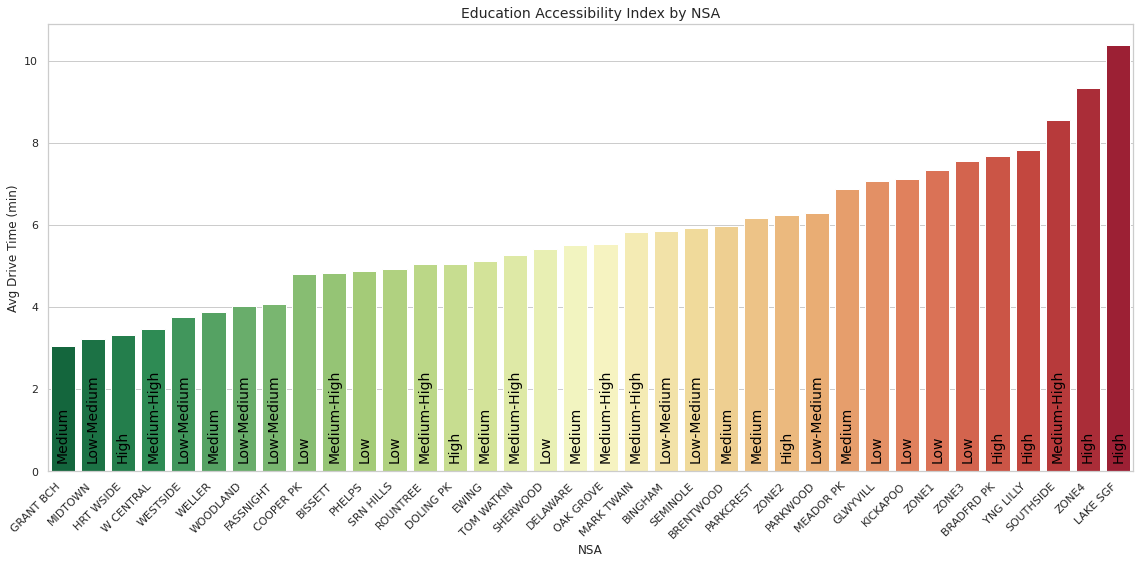

In [21]:
plt.figure(figsize=(16, 8))
barplot = sns.barplot(
    data=education_sorted,
    x='nsa',
    y='Education_Index',
    palette='RdYlGn_r'
)

plt.title("Education Accessibility Index by NSA", fontsize=14)
plt.ylabel("Avg Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Label at the base of each bar
for index, row in education_sorted.iterrows():
    barplot.text(
        index,
        0.2,
        row['Education_Category'],
        color='black',
        ha='center',
        va='bottom',
        fontsize=14,
        rotation=90
    )

plt.tight_layout()
plt.show()

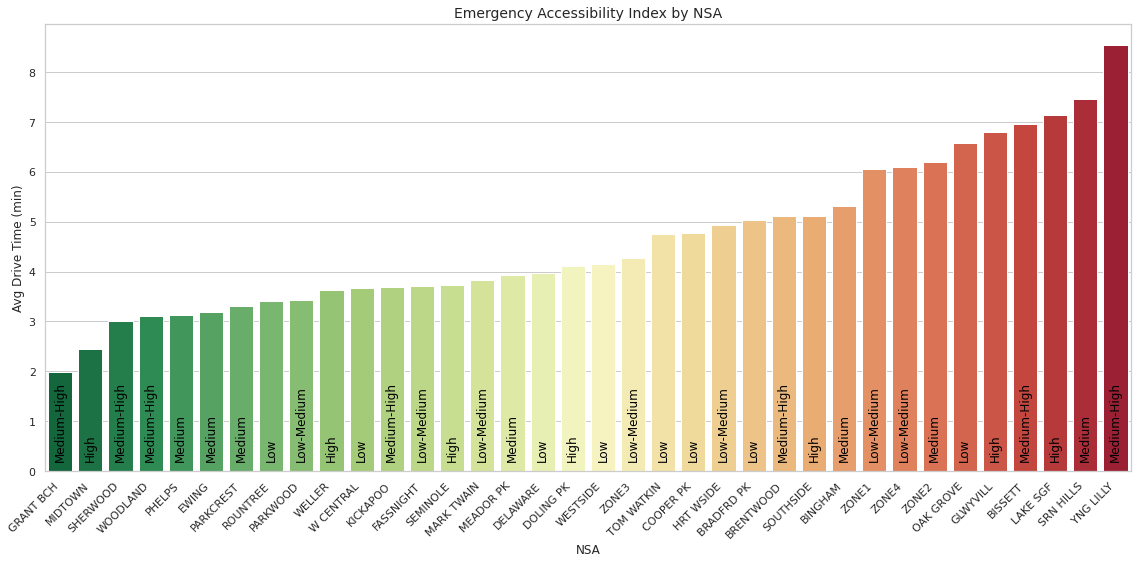

In [22]:
plt.figure(figsize=(16, 8))
barplot = sns.barplot(
    data=emergency_sorted,
    x='nsa',
    y='Emergency_Index',
    palette='RdYlGn_r'
)

plt.title("Emergency Accessibility Index by NSA", fontsize=14)
plt.ylabel("Avg Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Label at the base of each bar
for index, row in emergency_sorted.iterrows():
    barplot.text(
        index, 
        0.2,
        row['Emergency_Category'],
        color='black',
        ha='center',
        va='bottom',
        fontsize=12,
        rotation=90
    )

plt.tight_layout()
plt.show()

In [23]:
# Recreate accessibility category setup
healthcare_cols = ['drive_time_hospital', 'drive_time_nursing_home', 'drive_time_public_health']
education_cols = [
    'drive_time_early_childhood_school', 'drive_time_elementary_school',
    'drive_time_middle_school', 'drive_time_high_school'
]
emergency_cols = ['drive_time_fire', 'drive_time_police']

# Group and calculate averages
nsa_accessibility = df.groupby("nsa")[healthcare_cols + education_cols + emergency_cols].median()
nsa_accessibility['Healthcare_Index'] = nsa_accessibility[healthcare_cols].mean(axis=1)
nsa_accessibility['Education_Index'] = nsa_accessibility[education_cols].mean(axis=1)
nsa_accessibility['Emergency_Index'] = nsa_accessibility[emergency_cols].mean(axis=1)

# Categorization function
def categorize_index(series):
    return pd.qcut(series, q=5, labels=["Low", "Low-Medium", "Medium", "Medium-High", "High"])

# Apply categories
nsa_accessibility['Healthcare_Category'] = categorize_index(nsa_accessibility['Healthcare_Index'])
nsa_accessibility['Education_Category'] = categorize_index(nsa_accessibility['Education_Index'])
nsa_accessibility['Emergency_Category'] = categorize_index(nsa_accessibility['Emergency_Index'])

# Prepare final categorized table
categorized_access = nsa_accessibility[[
    'Healthcare_Category', 'Education_Category', 'Emergency_Category'
]].reset_index()

# Count how many times each NSA is flagged as High
categorized_access['High_Count'] = categorized_access[[
    'Healthcare_Category', 'Education_Category', 'Emergency_Category'
]].apply(lambda x: sum(x == 'High'), axis=1)

# Filter NSAs with 2 or more High flags
priority_table = categorized_access[categorized_access['High_Count'] >= 2]

priority_table

,nsa,Healthcare_Category,Education_Category,Emergency_Category,High_Count
9,GLWYVILL,High,Medium-High,High,2
13,LAKE SGF,High,High,High,3
25,SRN HILLS,High,Low-Medium,High,2
31,YNG LILLY,High,High,High,3
32,ZONE1,High,High,Medium-High,2
34,ZONE3,High,High,Medium,2
35,ZONE4,High,High,Medium-High,2


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


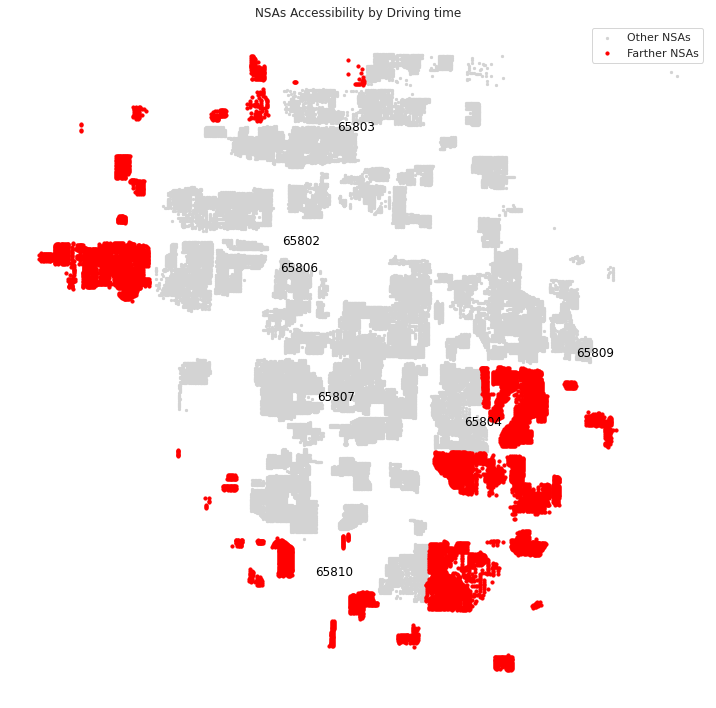

In [24]:
# Ensure all values in 'home_geolocation' are strings before applying wkt.loads
df['home_geolocation'] = df['home_geolocation'].astype(str)
df['geometry'] = df['home_geolocation'].apply(wkt.loads)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:26915")

# Flag priority NSAs
high_high_nsas = priority_table['nsa'].tolist()
gdf['priority_flag'] = gdf['nsa'].apply(lambda x: 'Priority NSA' if x in high_high_nsas else 'Other')

# Calculate ZIP centroids and rename geometry properly
zip_centroids = gdf.dissolve(by='zip5', as_index=False).copy()
zip_centroids['centroid'] = zip_centroids.geometry.centroid
zip_centroids = zip_centroids[['zip5', 'centroid']]
zip_centroids = zip_centroids.rename(columns={'centroid': 'geometry'})
zip_centroids = gpd.GeoDataFrame(zip_centroids, geometry='geometry', crs=gdf.crs)

# Plot with ZIP code labels on top
fig, ax = plt.subplots(figsize=(12, 10))
gdf[gdf['priority_flag'] == 'Other'].plot(ax=ax, color='lightgrey', markersize=5, label='Other NSAs')
gdf[gdf['priority_flag'] == 'Priority NSA'].plot(ax=ax, color='red', markersize=10, label='Farther NSAs')

# Add ZIP code labels at centroids
for idx, row in zip_centroids.iterrows():
    ax.annotate(text=str(row['zip5']), xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=12, color='black')

plt.title("NSAs Accessibility by Driving time")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()

# Categorizing NSA Accessibility

In [25]:
# Define updated categorization function
def custom_access_category(value):
    if value <= 3:
        return "Very Close"
    elif 4 <= value <= 6:
        return "Close"
    elif 7 <= value <= 9:
        return "Moderately Far"
    else:
        return "Far"

# Define the accessibility index columns for each category
healthcare_cols = [
    'drive_time_hospital', 'drive_time_nursing_home', 'drive_time_public_health'
]
education_cols = [
    'drive_time_early_childhood_school', 'drive_time_elementary_school',
    'drive_time_middle_school', 'drive_time_high_school'
]
emergency_cols = [
    'drive_time_fire', 'drive_time_police'
]

# Compute median drive times by NSA and scale up (rounded)
nsa_accessibility = df.groupby("nsa")[healthcare_cols + education_cols + emergency_cols].median().round()

# Create category-specific accessibility indices (rounded averages)
nsa_accessibility['Healthcare_Index'] = nsa_accessibility[healthcare_cols].mean(axis=1).round()
nsa_accessibility['Education_Index'] = nsa_accessibility[education_cols].mean(axis=1).round()
nsa_accessibility['Emergency_Index'] = nsa_accessibility[emergency_cols].mean(axis=1).round()

# Apply the custom categorization
nsa_accessibility['Healthcare_Category'] = nsa_accessibility['Healthcare_Index'].apply(custom_access_category)
nsa_accessibility['Education_Category'] = nsa_accessibility['Education_Index'].apply(custom_access_category)
nsa_accessibility['Emergency_Category'] = nsa_accessibility['Emergency_Index'].apply(custom_access_category)

# Prepare final display DataFrame
categorized_access_custom = nsa_accessibility[[
    'Healthcare_Index', 'Healthcare_Category',
    'Education_Index', 'Education_Category',
    'Emergency_Index', 'Emergency_Category'
]].reset_index()

categorized_access_custom

,nsa,Healthcare_Index,Healthcare_Category,Education_Index,Education_Category,Emergency_Index,Emergency_Category
0,BINGHAM,9.0,Moderately Far,6.0,Close,6.0,Close
1,BISSETT,7.0,Moderately Far,5.0,Close,7.0,Moderately Far
2,BRADFRD PK,6.0,Close,8.0,Moderately Far,5.0,Close
3,BRENTWOOD,7.0,Moderately Far,6.0,Close,5.0,Close
4,COOPER PK,9.0,Moderately Far,5.0,Close,5.0,Close
5,DELAWARE,5.0,Close,5.0,Close,4.0,Close
6,DOLING PK,5.0,Close,5.0,Close,4.0,Close
7,EWING,7.0,Moderately Far,5.0,Close,3.0,Very Close
8,FASSNIGHT,5.0,Close,4.0,Close,4.0,Close
9,GLWYVILL,10.0,Far,7.0,Moderately Far,7.0,Moderately Far


### NSA Counts per service type

In [26]:
# Redefine the required column sets
healthcare_cols = [
    'drive_time_hospital', 'drive_time_nursing_home', 'drive_time_public_health'
]
education_cols = [
    'drive_time_early_childhood_school', 'drive_time_elementary_school',
    'drive_time_middle_school', 'drive_time_high_school'
]
emergency_cols = [
    'drive_time_fire', 'drive_time_police'
]

# Group by NSA and compute median drive times
nsa_accessibility = df.groupby("nsa")[healthcare_cols + education_cols + emergency_cols].median().round()

# Compute category-specific accessibility indices
nsa_accessibility['Healthcare_Index'] = nsa_accessibility[healthcare_cols].mean(axis=1).round()
nsa_accessibility['Education_Index'] = nsa_accessibility[education_cols].mean(axis=1).round()
nsa_accessibility['Emergency_Index'] = nsa_accessibility[emergency_cols].mean(axis=1).round()

# Define function to bucket into ranges for counting
def bucket_minutes(value):
    if value <= 5:
        return "0-5 min"
    elif 6 <= value <= 9:
        return "6-9 min"
    else:
        return "10+ min"

# Apply bucketing
nsa_accessibility['Healthcare_Bucket'] = nsa_accessibility['Healthcare_Index'].apply(bucket_minutes)
nsa_accessibility['Education_Bucket'] = nsa_accessibility['Education_Index'].apply(bucket_minutes)
nsa_accessibility['Emergency_Bucket'] = nsa_accessibility['Emergency_Index'].apply(bucket_minutes)

# Count the number of NSAs in each bucket for each service
bucket_counts = {
    'Healthcare': nsa_accessibility['Healthcare_Bucket'].value_counts().sort_index(),
    'Education': nsa_accessibility['Education_Bucket'].value_counts().sort_index(),
    'Emergency': nsa_accessibility['Emergency_Bucket'].value_counts().sort_index()
}

# Combine into a single DataFrame for display
bucket_df = pd.DataFrame(bucket_counts).fillna(0).astype(int)
print(bucket_df)

         Healthcare  Education  Emergency
0-5 min          10         17         26
10+ min           4          2          0
6-9 min          22         17         10


In [27]:
# Calculate percentage for each service type
bucket_percentage_df = bucket_df.div(bucket_df.sum()) * 100
bucket_percentage_df = bucket_percentage_df.round(1)  # Round to 1 decimal place for readability
print(bucket_percentage_df)

         Healthcare  Education  Emergency
0-5 min        27.8       47.2       72.2
10+ min        11.1        5.6        0.0
6-9 min        61.1       47.2       27.8


## Plot all categories

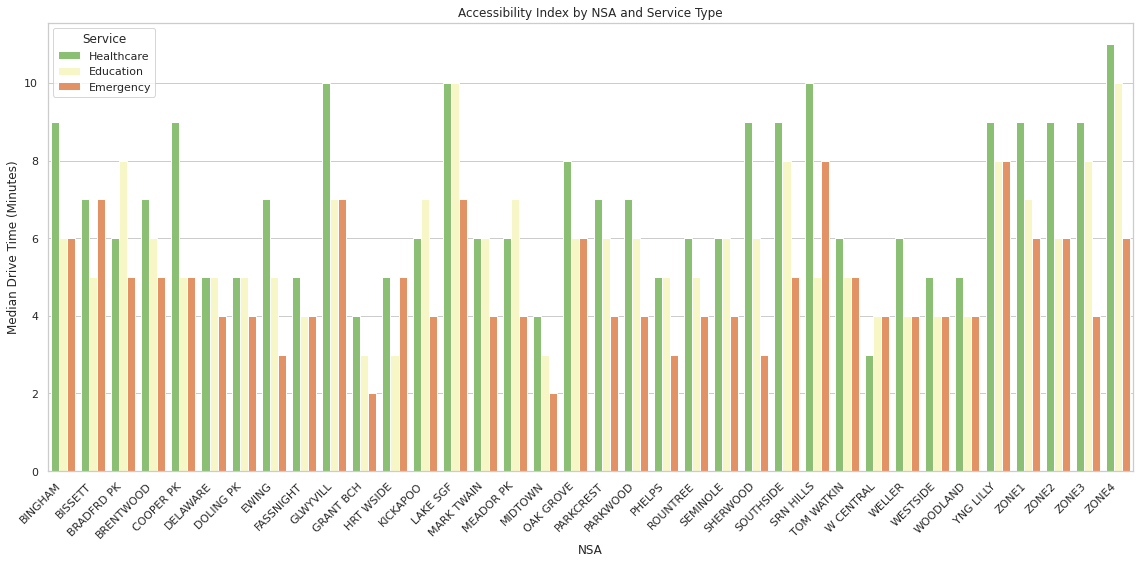

In [28]:
# Set consistent style
sns.set(style="whitegrid")

# Melt the dataset for easier grouped barplot
melted_df = categorized_access_custom.melt(
    id_vars='nsa',
    value_vars=['Healthcare_Index', 'Education_Index', 'Emergency_Index'],
    var_name='Service',
    value_name='Avg_Drive_Time'
)

# Clean labels
melted_df['Service'] = melted_df['Service'].str.replace('_Index', '')

# Create bar plot
plt.figure(figsize=(16, 8))
sns.barplot(data=melted_df, x='nsa', y='Avg_Drive_Time', hue='Service', palette='RdYlGn_r')

plt.title("Accessibility Index by NSA and Service Type")
plt.ylabel("Median Drive Time (Minutes)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Service")
plt.tight_layout()
plt.show()

### Healthcare Accessibility Chart

<Figure size 1152x432 with 0 Axes>

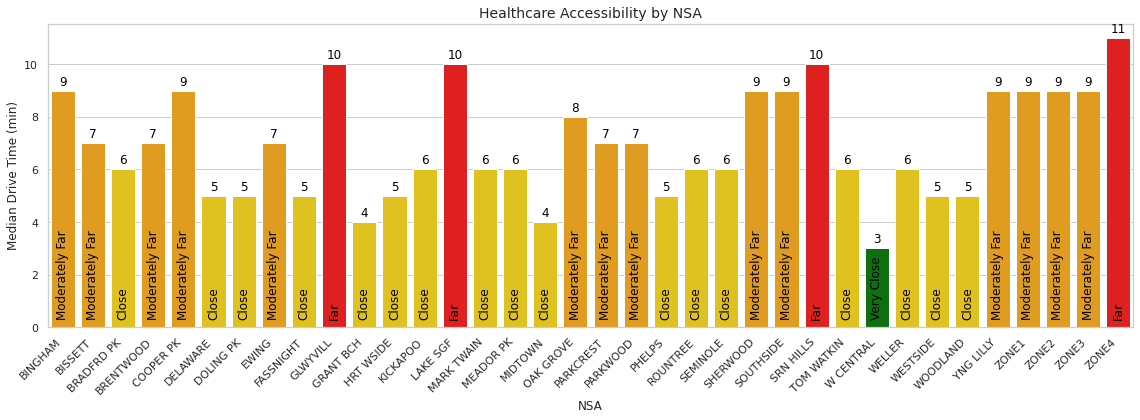

In [29]:
plt.figure(figsize=(16, 6))
color_map = {
    'Very Close': 'green',
    'Close': 'gold',
    'Moderately Far': 'orange',
    'Far': 'red'
}

plt.figure(figsize=(16, 6))
colors = categorized_access_custom['Healthcare_Category'].map(color_map)

barplot = sns.barplot(
    data=categorized_access_custom,
    x='nsa',
    y='Healthcare_Index',
    palette=colors
)

plt.title("Healthcare Accessibility by NSA", fontsize=14)
plt.ylabel("Median Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Add category label at base + numeric value on top
for index, row in categorized_access_custom.iterrows():
    # Category label
    barplot.text(
        index,
        0.3,
        row['Healthcare_Category'],
        color='black',
        ha='center',
        va='bottom',
        fontsize=12,
        rotation=90
    )
    # Drive time value
    barplot.text(
        index,
        row['Healthcare_Index'] + 0.1,
        f"{row['Healthcare_Index']:.0f}",
        color='black',
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.tight_layout()
plt.show()

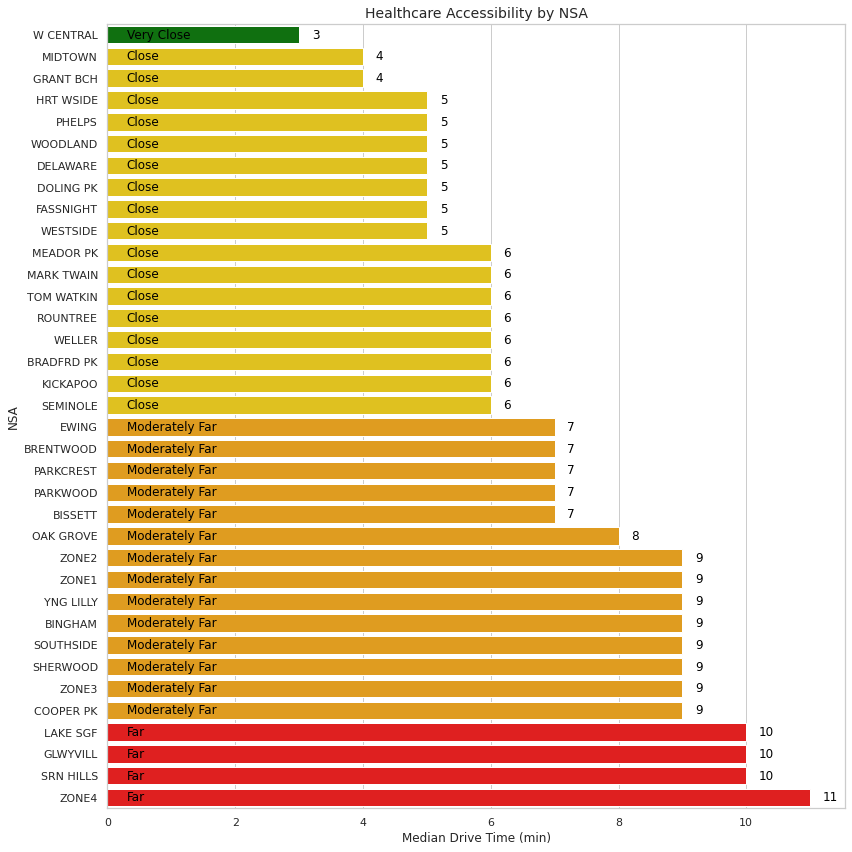

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define color map
color_map = {
    'Very Close': 'green',
    'Close': 'gold',
    'Moderately Far': 'orange',
    'Far': 'red'
}

# Sort by Healthcare_Index
sorted_data = categorized_access_custom.sort_values('Healthcare_Index', ascending=True).reset_index(drop=True)

# Map colors
colors = sorted_data['Healthcare_Category'].map(color_map)

# Plot
plt.figure(figsize=(12, 12))  # taller for better vertical space
barplot = sns.barplot(
    data=sorted_data,
    y='nsa',
    x='Healthcare_Index',
    palette=colors
)

plt.title("Healthcare Accessibility by NSA", fontsize=14)
plt.xlabel("Median Drive Time (min)")
plt.ylabel("NSA")

# Add category label + drive time on each bar
for index, row in sorted_data.iterrows():
    # Category label on the left
    barplot.text(
        0.3,
        index,
        row['Healthcare_Category'],
        color='black',
        ha='left',
        va='center',
        fontsize=12
    )
    # Drive time on the right
    barplot.text(
        row['Healthcare_Index'] + 0.2,
        index,
        f"{row['Healthcare_Index']:.0f}",
        color='black',
        ha='left',
        va='center',
        fontsize=12
    )

plt.tight_layout()
plt.show()

In [31]:
# Filter for rows where Healthcare Index is <= 5 minutes
within_5_min = categorized_access_custom[categorized_access_custom['Healthcare_Index'] <= 5]

# Sort by Healthcare_Index ascending (best access first)
top10_healthcare = within_5_min.sort_values('Healthcare_Index').head(10)

# Display the result
top10_healthcare[['nsa', 'Healthcare_Index', 'Healthcare_Category']]

,nsa,Healthcare_Index,Healthcare_Category
27,W CENTRAL,3.0,Very Close
10,GRANT BCH,4.0,Close
16,MIDTOWN,4.0,Close
5,DELAWARE,5.0,Close
6,DOLING PK,5.0,Close
8,FASSNIGHT,5.0,Close
11,HRT WSIDE,5.0,Close
20,PHELPS,5.0,Close
29,WESTSIDE,5.0,Close
30,WOODLAND,5.0,Close


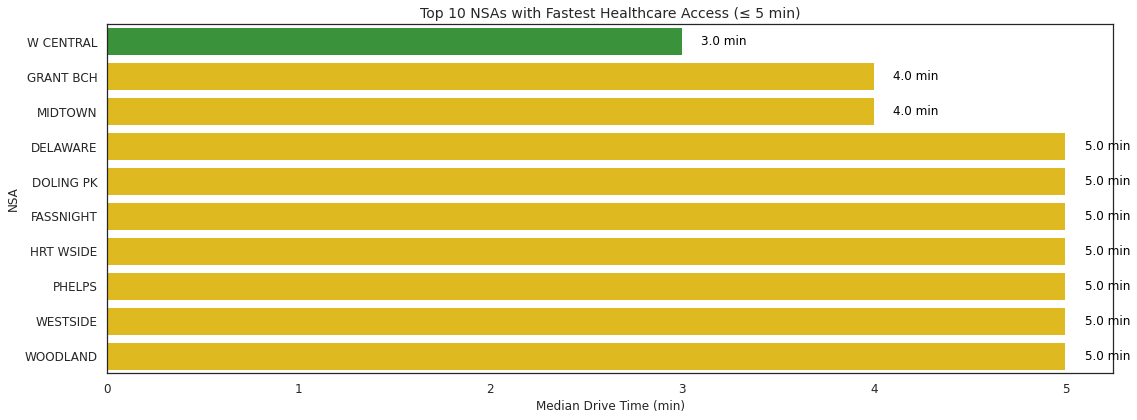

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter and sort the top 10 NSAs with Healthcare Index ≤ 5
top10_healthcare = categorized_access_custom[
    categorized_access_custom['Healthcare_Index'] <= 5
].sort_values('Healthcare_Index').head(10)

# Color map
color_map = {
    'Very Close': '#2ca02c',
    'Close': '#ffcc00',
    'Moderately Far': '#ff7f0e',
    'Far': '#d62728'
}

# Map colors
colors = top10_healthcare['Healthcare_Category'].map(color_map)

# Set style without grid
sns.set_style("white")

# Plot
plt.figure(figsize=(16, 6))
barplot = sns.barplot(
    data=top10_healthcare,
    y='nsa',
    x='Healthcare_Index',
    palette=colors
)

# Title and axis labels
plt.title("Top 10 NSAs with Fastest Healthcare Access (≤ 5 min)", fontsize=14)
plt.xlabel("Median Drive Time (min)", fontsize=12)
plt.ylabel("NSA", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove gridlines
plt.grid(False)

# Annotate drive time
for i, (index, row) in enumerate(top10_healthcare.iterrows()):
    barplot.text(
        row['Healthcare_Index'] + 0.1,
        i,
        f"{row['Healthcare_Index']:.1f} min",
        color='black',
        va='center',
        fontsize=12
    )

plt.tight_layout()
plt.show()

### Education Accessibility Chart

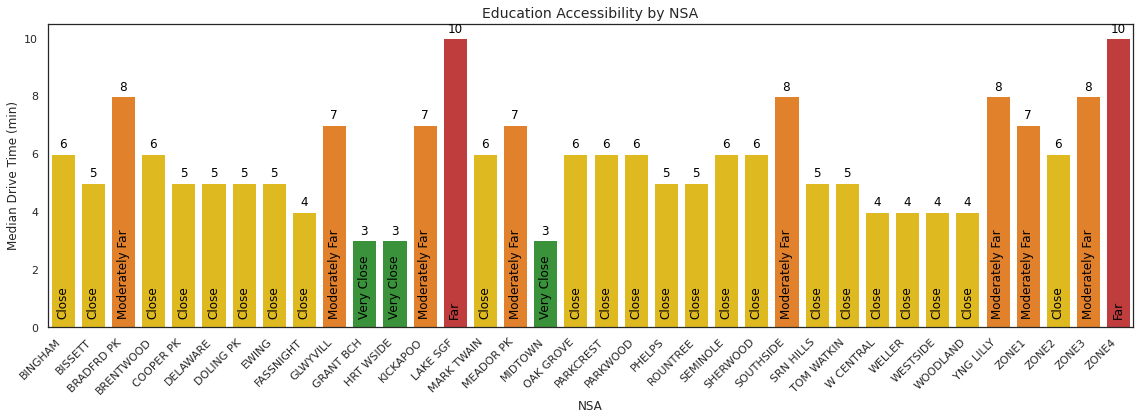

In [33]:
plt.figure(figsize=(16, 6))
colors = categorized_access_custom['Education_Category'].map(color_map)

barplot = sns.barplot(
    data=categorized_access_custom,
    x='nsa',
    y='Education_Index',
    palette=colors
)

plt.title("Education Accessibility by NSA", fontsize=14)
plt.ylabel("Median Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Add category label at base of each bar + drive time on top
for index, row in categorized_access_custom.iterrows():
    # Category label
    barplot.text(
        index,
        0.3,
        row['Education_Category'],
        color='black',
        ha='center',
        va='bottom',
        fontsize=12,
        rotation=90
    )
    # Drive time value
    barplot.text(
        index,
        row['Education_Index'] + 0.1,
        f"{row['Education_Index']:.0f}",
        color='black',
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.tight_layout()
plt.show()

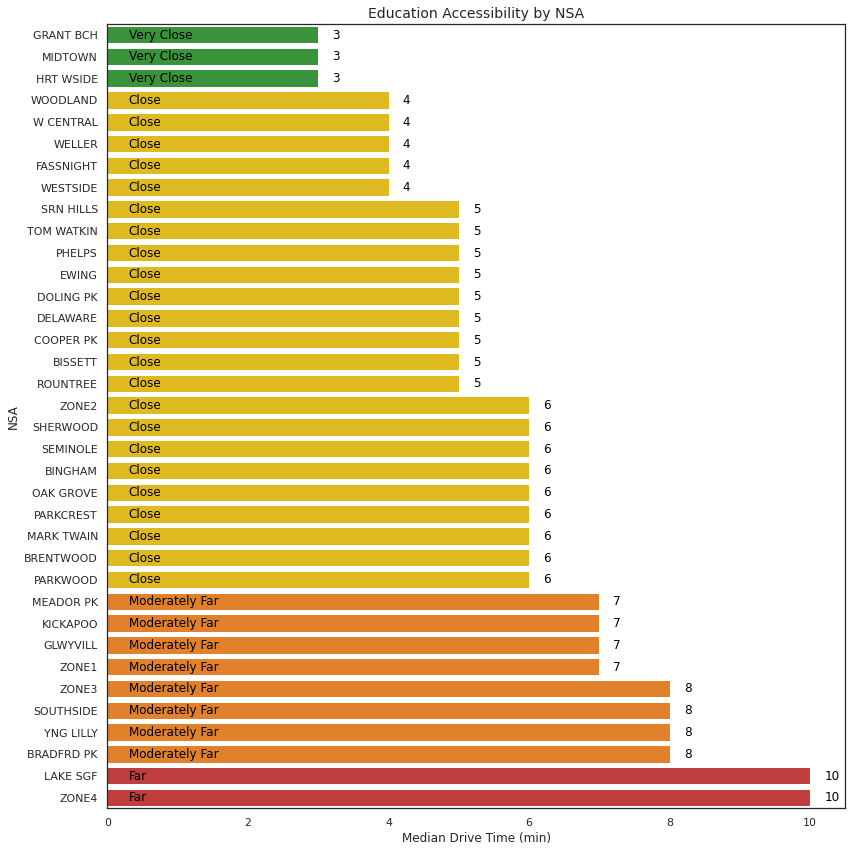

In [34]:
# Sort by Education Index
education_sorted = categorized_access_custom.sort_values('Education_Index').reset_index(drop=True)

# Map colors
colors = education_sorted['Education_Category'].map(color_map)

# Plot
plt.figure(figsize=(12, 12))
barplot = sns.barplot(
    data=education_sorted,
    y='nsa',
    x='Education_Index',
    palette=colors
)

plt.title("Education Accessibility by NSA", fontsize=14)
plt.xlabel("Median Drive Time (min)")
plt.ylabel("NSA")

# Add labels
for index, row in education_sorted.iterrows():
    plt.text(0.3, index, row['Education_Category'],
             ha='left', va='center', fontsize=12, color='black')
    plt.text(row['Education_Index'] + 0.2, index, f"{row['Education_Index']:.0f}",
             ha='left', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [35]:
# Filter for rows where Education Index is <= 5 minutes
within_5_min_edu = categorized_access_custom[categorized_access_custom['Education_Index'] <= 5]

# Sort by Education_Index ascending (best access first)
top10_education = within_5_min_edu.sort_values('Education_Index').head(10)

# Display the result
top10_education[['nsa', 'Education_Index', 'Education_Category']]

,nsa,Education_Index,Education_Category
16,MIDTOWN,3.0,Very Close
11,HRT WSIDE,3.0,Very Close
10,GRANT BCH,3.0,Very Close
28,WELLER,4.0,Close
27,W CENTRAL,4.0,Close
29,WESTSIDE,4.0,Close
30,WOODLAND,4.0,Close
8,FASSNIGHT,4.0,Close
7,EWING,5.0,Close
6,DOLING PK,5.0,Close


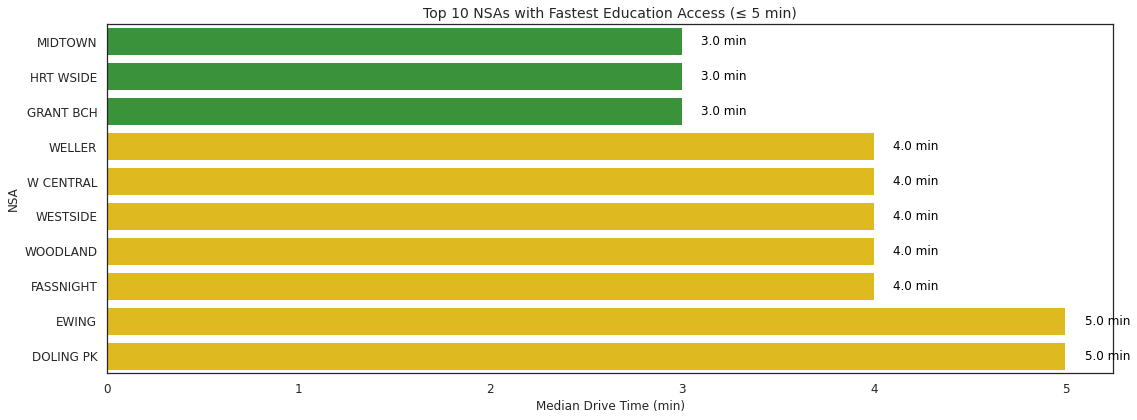

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter and sort the top 10 NSAs with Education Index ≤ 5
top10_education = categorized_access_custom[
    categorized_access_custom['Education_Index'] <= 5
].sort_values('Education_Index').head(10)

# Color map
color_map = {
    'Very Close': '#2ca02c',
    'Close': '#ffcc00',
    'Moderately Far': '#ff7f0e',
    'Far': '#d62728'
}

# Map colors
colors = top10_education['Education_Category'].map(color_map)

# Set style without grid
sns.set_style("white")

# Plot
plt.figure(figsize=(16, 6))
barplot = sns.barplot(
    data=top10_education,
    y='nsa',
    x='Education_Index',
    palette=colors
)

# Titles and axis labels
plt.title("Top 10 NSAs with Fastest Education Access (≤ 5 min)", fontsize=14)
plt.xlabel("Median Drive Time (min)", fontsize=12)
plt.ylabel("NSA", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove gridlines
plt.grid(False)

# Annotate drive time
for i, (index, row) in enumerate(top10_education.iterrows()):
    barplot.text(
        row['Education_Index'] + 0.1,
        i,
        f"{row['Education_Index']:.1f} min",
        color='black',
        va='center',
        fontsize=12
    )

plt.tight_layout()
plt.show()

### Emergency Accessibility Chart

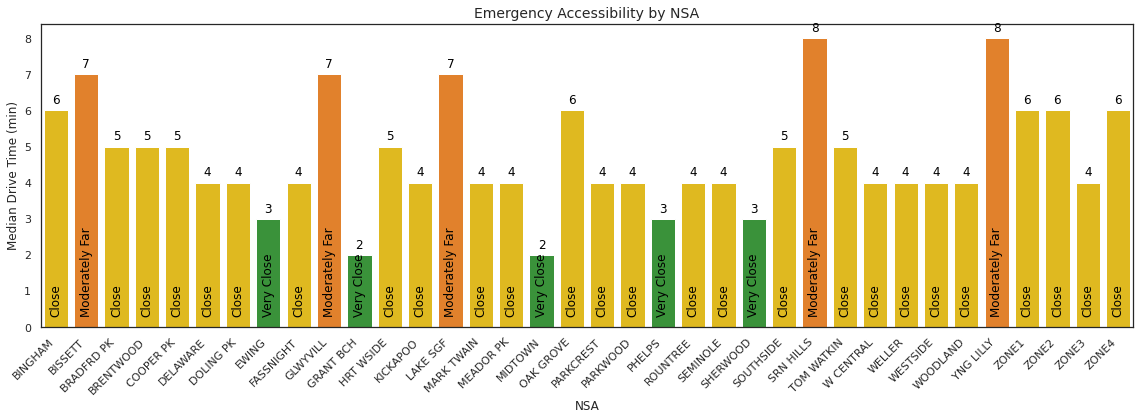

In [37]:
plt.figure(figsize=(16, 6))
colors = categorized_access_custom['Emergency_Category'].map(color_map)

barplot = sns.barplot(
    data=categorized_access_custom,
    x='nsa',
    y='Emergency_Index',
    palette=colors
)

plt.title("Emergency Accessibility by NSA", fontsize=14)
plt.ylabel("Median Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Add category label at base of each bar + drive time on top
for index, row in categorized_access_custom.iterrows():
    # Category label
    barplot.text(
        index,
        0.3,
        row['Emergency_Category'],
        color='black',
        ha='center',
        va='bottom',
        fontsize=12,
        rotation=90
    )
    # Drive time value
    barplot.text(
        index,
        row['Emergency_Index'] + 0.1,
        f"{row['Emergency_Index']:.0f}",
        color='black',
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.tight_layout()
plt.show()

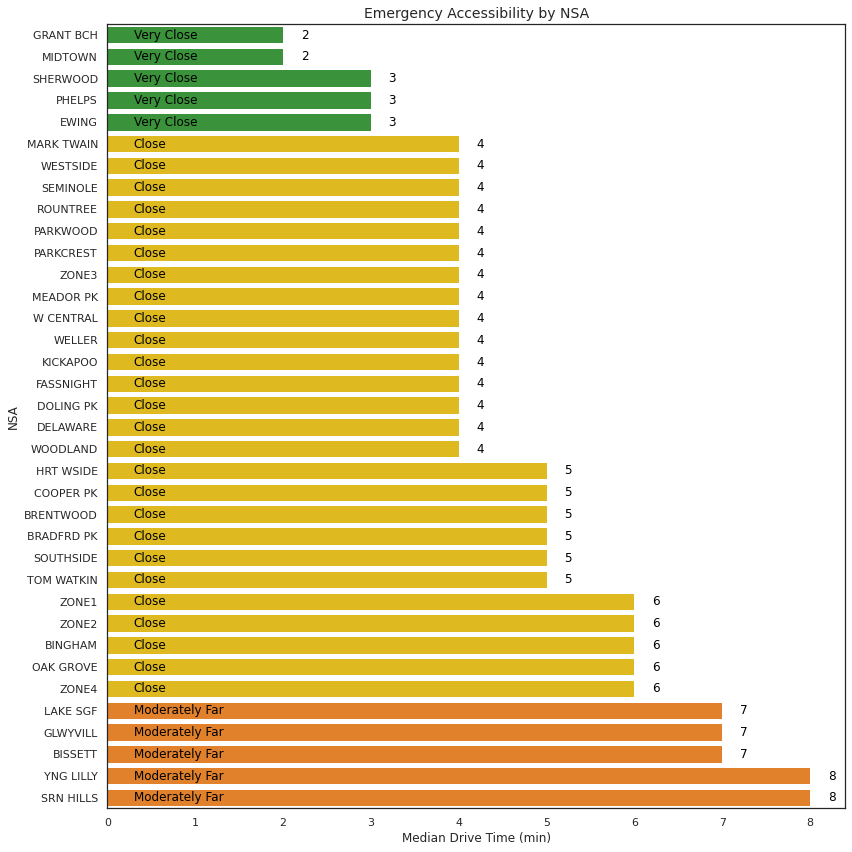

In [38]:
# Sort by Emergency Index
emergency_sorted = categorized_access_custom.sort_values('Emergency_Index').reset_index(drop=True)

# Map colors
colors = emergency_sorted['Emergency_Category'].map(color_map)

# Plot
plt.figure(figsize=(12, 12))
barplot = sns.barplot(
    data=emergency_sorted,
    y='nsa',
    x='Emergency_Index',
    palette=colors
)

plt.title("Emergency Accessibility by NSA", fontsize=14)
plt.xlabel("Median Drive Time (min)")
plt.ylabel("NSA")

# Add labels
for index, row in emergency_sorted.iterrows():
    plt.text(0.3, index, row['Emergency_Category'],
             ha='left', va='center', fontsize=12, color='black')
    plt.text(row['Emergency_Index'] + 0.2, index, f"{row['Emergency_Index']:.0f}",
             ha='left', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [39]:
# Filter for rows where Emergency Index is <= 5 minutes
within_5_min_emergency = categorized_access_custom[categorized_access_custom['Emergency_Index'] <= 5]

# Sort by Emergency_Index ascending (best access first)
top10_emergency = within_5_min_emergency.sort_values('Emergency_Index').head(10)

# Display the result
top10_emergency[['nsa', 'Emergency_Index', 'Emergency_Category']]


,nsa,Emergency_Index,Emergency_Category
16,MIDTOWN,2.0,Very Close
10,GRANT BCH,2.0,Very Close
23,SHERWOOD,3.0,Very Close
7,EWING,3.0,Very Close
20,PHELPS,3.0,Very Close
29,WESTSIDE,4.0,Close
28,WELLER,4.0,Close
27,W CENTRAL,4.0,Close
22,SEMINOLE,4.0,Close
21,ROUNTREE,4.0,Close


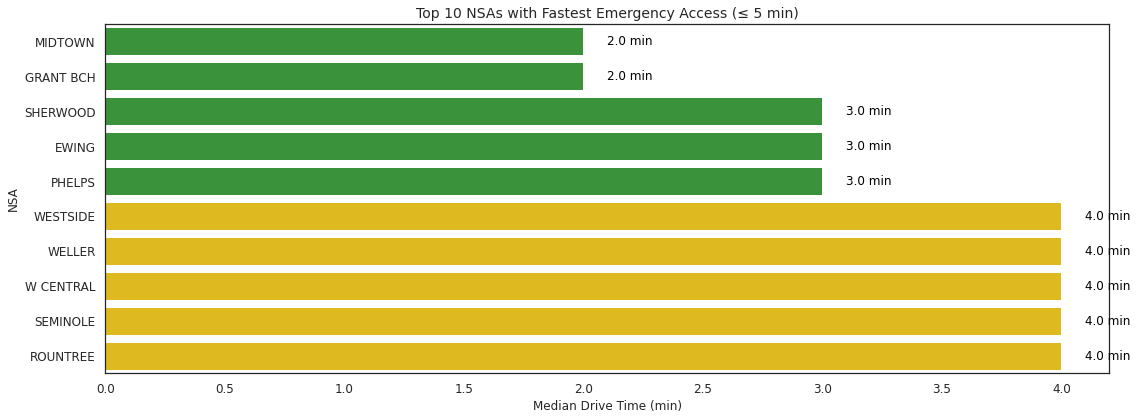

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter and sort the top 10 NSAs with Emergency Index ≤ 5
top10_emergency = categorized_access_custom[
    categorized_access_custom['Emergency_Index'] <= 5
].sort_values('Emergency_Index').head(10)

# Color map
color_map = {
    'Very Close': '#2ca02c',
    'Close': '#ffcc00',
    'Moderately Far': '#ff7f0e',
    'Far': '#d62728'
}

# Map colors
colors = top10_emergency['Emergency_Category'].map(color_map)

# Set clean white style
sns.set_style("white")

# Plot
plt.figure(figsize=(16, 6))
barplot = sns.barplot(
    data=top10_emergency,
    y='nsa',
    x='Emergency_Index',
    palette=colors
)

# Title and axis labels
plt.title("Top 10 NSAs with Fastest Emergency Access (≤ 5 min)", fontsize=14)
plt.xlabel("Median Drive Time (min)", fontsize=12)
plt.ylabel("NSA", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove grid
plt.grid(False)

# Annotate drive time
for i, (index, row) in enumerate(top10_emergency.iterrows()):
    barplot.text(
        row['Emergency_Index'] + 0.1,
        i,
        f"{row['Emergency_Index']:.1f} min",
        color='black',
        va='center',
        fontsize=12
    )

plt.tight_layout()
plt.show()


In [41]:
# Step 1: Filter top 10 for each accessibility type (already within 5 minutes)
top10_healthcare = categorized_access_custom[categorized_access_custom['Healthcare_Index'] <= 5].sort_values('Healthcare_Index').head(10)
top10_healthcare = top10_healthcare[['nsa', 'Healthcare_Index']].copy()
top10_healthcare['Type'] = 'Healthcare'

top10_education = categorized_access_custom[categorized_access_custom['Education_Index'] <= 5].sort_values('Education_Index').head(10)
top10_education = top10_education[['nsa', 'Education_Index']].copy()
top10_education['Type'] = 'Education'

top10_emergency = categorized_access_custom[categorized_access_custom['Emergency_Index'] <= 5].sort_values('Emergency_Index').head(10)
top10_emergency = top10_emergency[['nsa', 'Emergency_Index']].copy()
top10_emergency['Type'] = 'Emergency'

# Step 2: Rename columns to a common name for merging
top10_healthcare.rename(columns={'Healthcare_Index': 'Drive_Time'}, inplace=True)
top10_education.rename(columns={'Education_Index': 'Drive_Time'}, inplace=True)
top10_emergency.rename(columns={'Emergency_Index': 'Drive_Time'}, inplace=True)

# Step 3: Concatenate all three
combined_top10 = pd.concat([top10_healthcare, top10_education, top10_emergency], ignore_index=True)

# Step 4: Sort from closest to farthest
combined_top10_sorted = combined_top10.sort_values('Drive_Time').reset_index(drop=True)

# Display result
combined_top10_sorted

,nsa,Drive_Time,Type
0,GRANT BCH,2.0,Emergency
1,MIDTOWN,2.0,Emergency
2,W CENTRAL,3.0,Healthcare
3,PHELPS,3.0,Emergency
4,EWING,3.0,Emergency
5,SHERWOOD,3.0,Emergency
6,MIDTOWN,3.0,Education
7,HRT WSIDE,3.0,Education
8,GRANT BCH,3.0,Education
9,W CENTRAL,4.0,Emergency


### Top 10 Fastest Accessible NSAs grouped by Service Type

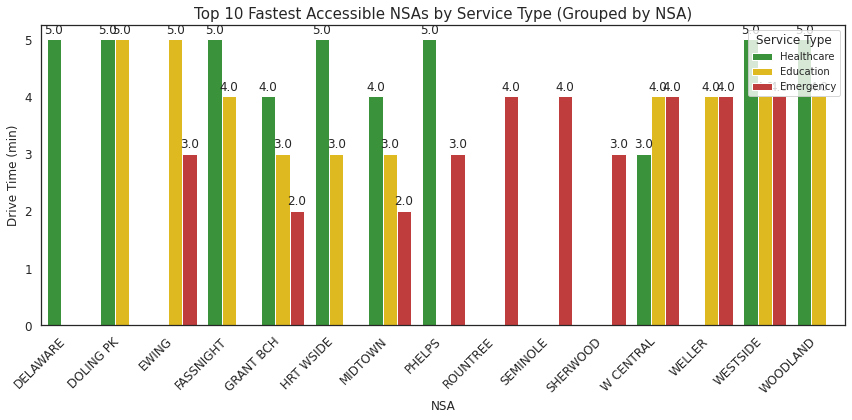

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set color palette
type_color_map = {
    'Healthcare': '#2ca02c',
    'Education': '#ffcc00',
    'Emergency': '#d62728'
}

# Sort by NSA (or optionally sort by min drive time per NSA)
combined_top10_grouped = combined_top10.sort_values(['nsa', 'Type']).reset_index(drop=True)

# Set up plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=combined_top10_grouped,
    x='nsa',
    y='Drive_Time',
    hue='Type',
    palette=type_color_map
)

# Title & axis
plt.title("Top 10 Fastest Accessible NSAs by Service Type (Grouped by NSA)", fontsize=15)
plt.xlabel("NSA", fontsize=12)
plt.ylabel("Drive Time (min)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Service Type", loc='upper right', fontsize=10, title_fontsize=12)

# Add value labels above bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.1f', label_type='edge', padding=3, fontsize=12)

plt.tight_layout()
plt.show()

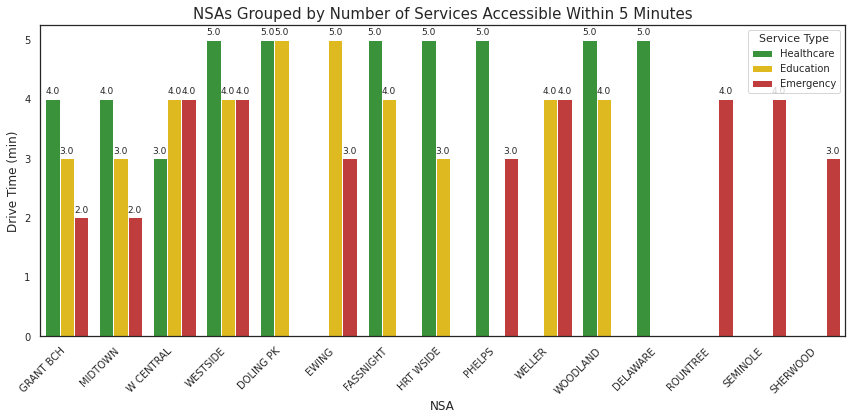

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a copy of the combined dataset
combined_top10_grouped = combined_top10.copy()

# Step 2: Add a flag for whether each service is within 5 minutes
combined_top10_grouped['Within_5_Min'] = combined_top10_grouped['Drive_Time'] <= 5

# Step 3: Count how many services per NSA are within 5 minutes
nsa_priority = (
    combined_top10_grouped.groupby('nsa')['Within_5_Min']
    .sum()
    .reset_index()
    .rename(columns={'Within_5_Min': 'Services_Within_5'})
)

# Step 4: Merge the priority rank back into the original dataframe
combined_top10_grouped = combined_top10_grouped.merge(nsa_priority, on='nsa')

# Step 5: Sort by Services_Within_5 (descending), then NSA (alpha)
combined_top10_grouped = combined_top10_grouped.sort_values(
    by=['Services_Within_5', 'nsa'], ascending=[False, True]
).reset_index(drop=True)

# Step 6: Plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=combined_top10_grouped,
    x='nsa',
    y='Drive_Time',
    hue='Type',
    palette={
        'Healthcare': '#2ca02c',
        'Education': '#ffcc00',
        'Emergency': '#d62728'
    }
)

# Plot styling
plt.title("NSAs Grouped by Number of Services Accessible Within 5 Minutes", fontsize=15)
plt.xlabel("NSA", fontsize=12)
plt.ylabel("Drive Time (min)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Service Type", loc='upper right', fontsize=10, title_fontsize=11)

# Add bar labels
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.1f', label_type='edge', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

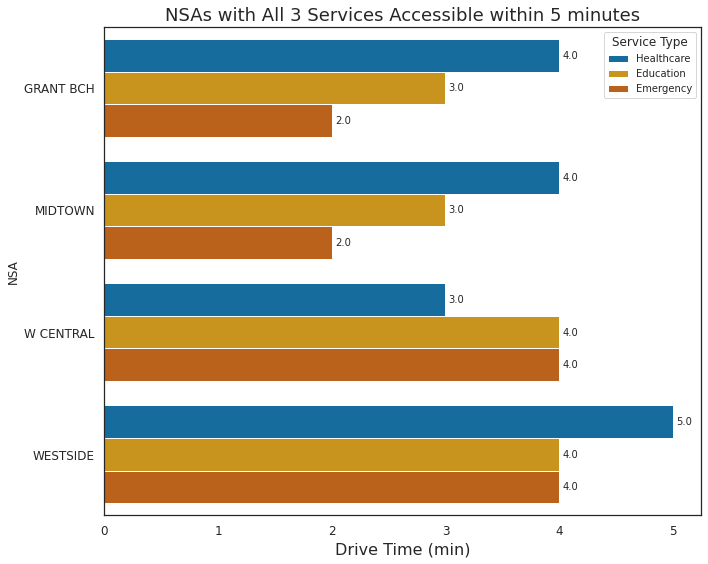

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a copy of the combined dataset
combined_top10_grouped = combined_top10.copy()

# Add a flag for whether each service is within 5 minutes
combined_top10_grouped['Within_5_Min'] = combined_top10_grouped['Drive_Time'] <= 5

# Count how many services per NSA are within 5 minutes
nsa_priority = (
    combined_top10_grouped.groupby('nsa')['Within_5_Min']
    .sum()
    .reset_index()
    .rename(columns={'Within_5_Min': 'Services_Within_5'})
)

# Merge the priority rank back into the original dataframe
combined_top10_grouped = combined_top10_grouped.merge(nsa_priority, on='nsa')

# Filter NSAs with all 3 service types
nsa_with_all_3 = (
    combined_top10_grouped.groupby('nsa')['Type']
    .nunique()
    .reset_index()
    .query('Type == 3')['nsa']
)

combined_top10_grouped = combined_top10_grouped[
    combined_top10_grouped['nsa'].isin(nsa_with_all_3)
]

# Sort by Services_Within_5 (descending), then NSA (alpha)
combined_top10_grouped = combined_top10_grouped.sort_values(
    by=['Services_Within_5', 'nsa'], ascending=[False, True]
).reset_index(drop=True)

# Plot with flipped axes
plt.figure(figsize=(10, 8))
barplot = sns.barplot(
    data=combined_top10_grouped,
    y='nsa',
    x='Drive_Time',
    hue='Type',
    palette={
        'Healthcare': '#0072B2',
        'Education': '#E69F00',
        'Emergency': '#D55E00'
    }
)

# Remove grid
plt.grid(False)

# Plot styling
plt.title("NSAs with All 3 Services Accessible within 5 minutes", fontsize=18)
plt.ylabel("NSA", fontsize=12)
plt.xlabel("Drive Time (min)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Service Type", loc='upper right', fontsize=10, title_fontsize=12)

# Add bar labels
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.1f', label_type='edge', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### Combined Multi-panel Version

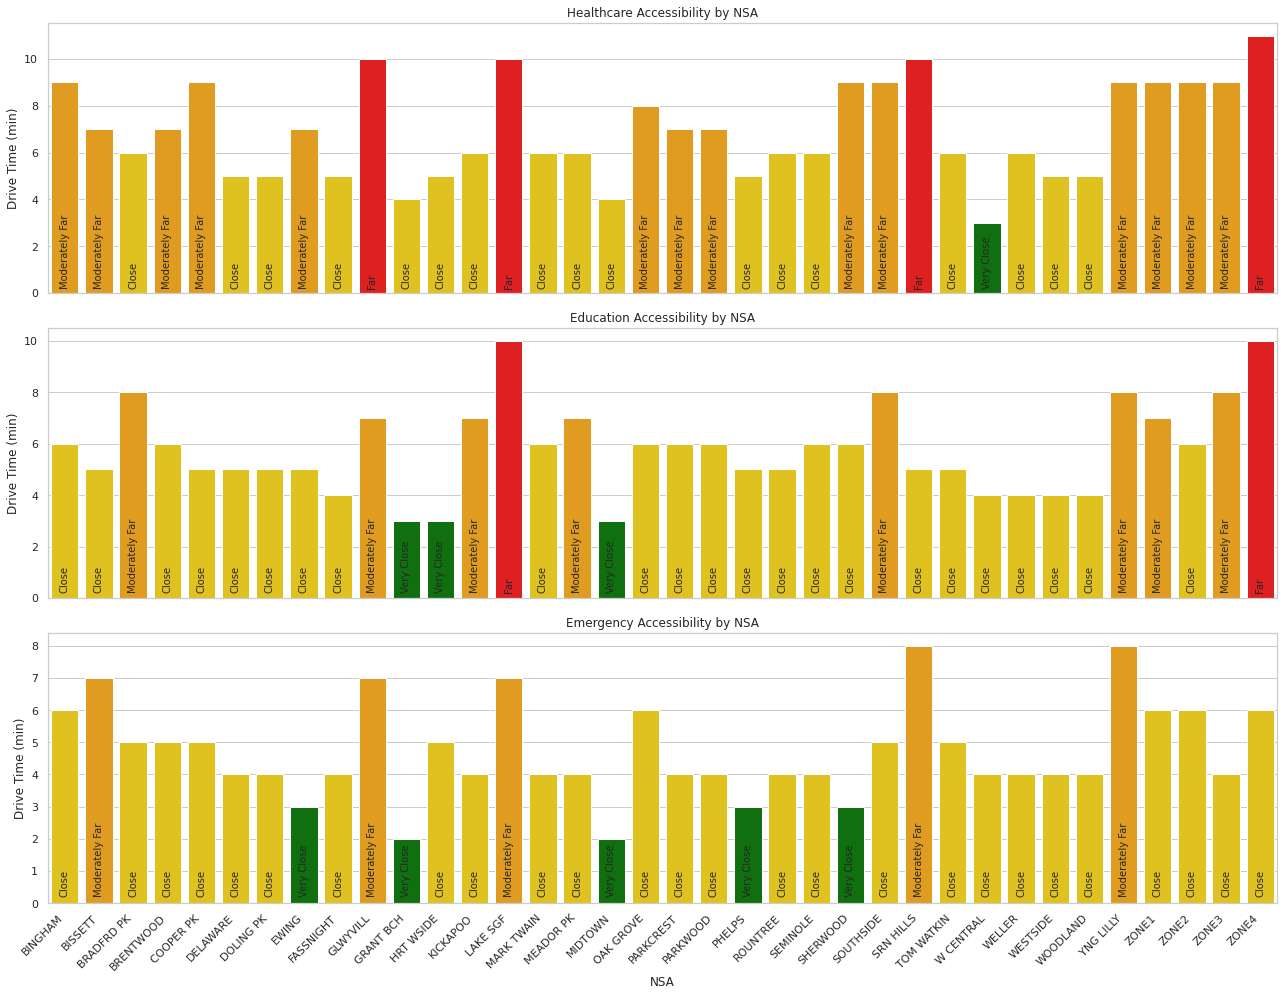

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent style
sns.set(style="whitegrid")

# Color mapping for categories
color_map = {
    'Very Close': 'green',
    'Close': 'gold',
    'Moderately Far': 'orange',
    'Far': 'red'
}

# Get individual color mappings for each index
healthcare_colors = categorized_access_custom['Healthcare_Category'].map(color_map)
education_colors = categorized_access_custom['Education_Category'].map(color_map)
emergency_colors = categorized_access_custom['Emergency_Category'].map(color_map)

# Create 3-panel figure
fig, axs = plt.subplots(3, 1, figsize=(18, 14), sharex=True)

# Plot Healthcare
sns.barplot(data=categorized_access_custom, x='nsa', y='Healthcare_Index',
            palette=healthcare_colors, ax=axs[0])
axs[0].set_title("Healthcare Accessibility by NSA")
axs[0].set_ylabel("Drive Time (min)")
axs[0].set_xlabel("")
for index, row in categorized_access_custom.iterrows():
    axs[0].text(index, 0.2, row['Healthcare_Category'], ha='center', va='bottom', rotation=90, fontsize=10)

# Plot Education
sns.barplot(data=categorized_access_custom, x='nsa', y='Education_Index',
            palette=education_colors, ax=axs[1])
axs[1].set_title("Education Accessibility by NSA")
axs[1].set_ylabel("Drive Time (min)")
axs[1].set_xlabel("")
for index, row in categorized_access_custom.iterrows():
    axs[1].text(index, 0.2, row['Education_Category'], ha='center', va='bottom', rotation=90, fontsize=10)

# Plot Emergency
sns.barplot(data=categorized_access_custom, x='nsa', y='Emergency_Index',
            palette=emergency_colors, ax=axs[2])
axs[2].set_title("Emergency Accessibility by NSA")
axs[2].set_ylabel("Drive Time (min)")
axs[2].set_xlabel("NSA")
for index, row in categorized_access_custom.iterrows():
    axs[2].text(index, 0.2, row['Emergency_Category'], ha='center', va='bottom', rotation=90, fontsize=10)

# Final formatting
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Sorted by NSA

In [46]:
# Rename NSA to lowercase if needed
if 'NSA' in df.columns:
    df.rename(columns={'NSA': 'nsa'}, inplace=True)

# Categorization function
def custom_access_category(value):
    if value <= 3:
        return "Very Close"
    elif 4 <= value <= 6:
        return "Close"
    elif 7 <= value <= 9:
        return "Moderately Far"
    else:
        return "Far"

# Define index columns
healthcare_cols = ['drive_time_hospital', 'drive_time_nursing_home', 'drive_time_public_health']
education_cols = ['drive_time_early_childhood_school', 'drive_time_elementary_school',
                  'drive_time_middle_school', 'drive_time_high_school']
emergency_cols = ['drive_time_fire', 'drive_time_police']

# Compute and round medians
nsa_accessibility = df.groupby("nsa")[healthcare_cols + education_cols + emergency_cols].median().round()

# Compute average index scores
nsa_accessibility['Healthcare_Index'] = nsa_accessibility[healthcare_cols].mean(axis=1).round()
nsa_accessibility['Education_Index'] = nsa_accessibility[education_cols].mean(axis=1).round()
nsa_accessibility['Emergency_Index'] = nsa_accessibility[emergency_cols].mean(axis=1).round()

# Apply custom categories
nsa_accessibility['Healthcare_Category'] = nsa_accessibility['Healthcare_Index'].apply(custom_access_category)
nsa_accessibility['Education_Category'] = nsa_accessibility['Education_Index'].apply(custom_access_category)
nsa_accessibility['Emergency_Category'] = nsa_accessibility['Emergency_Index'].apply(custom_access_category)

# Create final sorted DataFrames
categorized_access_custom = nsa_accessibility.reset_index()
healthcare_sorted = categorized_access_custom.sort_values(by='Healthcare_Index')
education_sorted = categorized_access_custom.sort_values(by='Education_Index')
emergency_sorted = categorized_access_custom.sort_values(by='Emergency_Index')

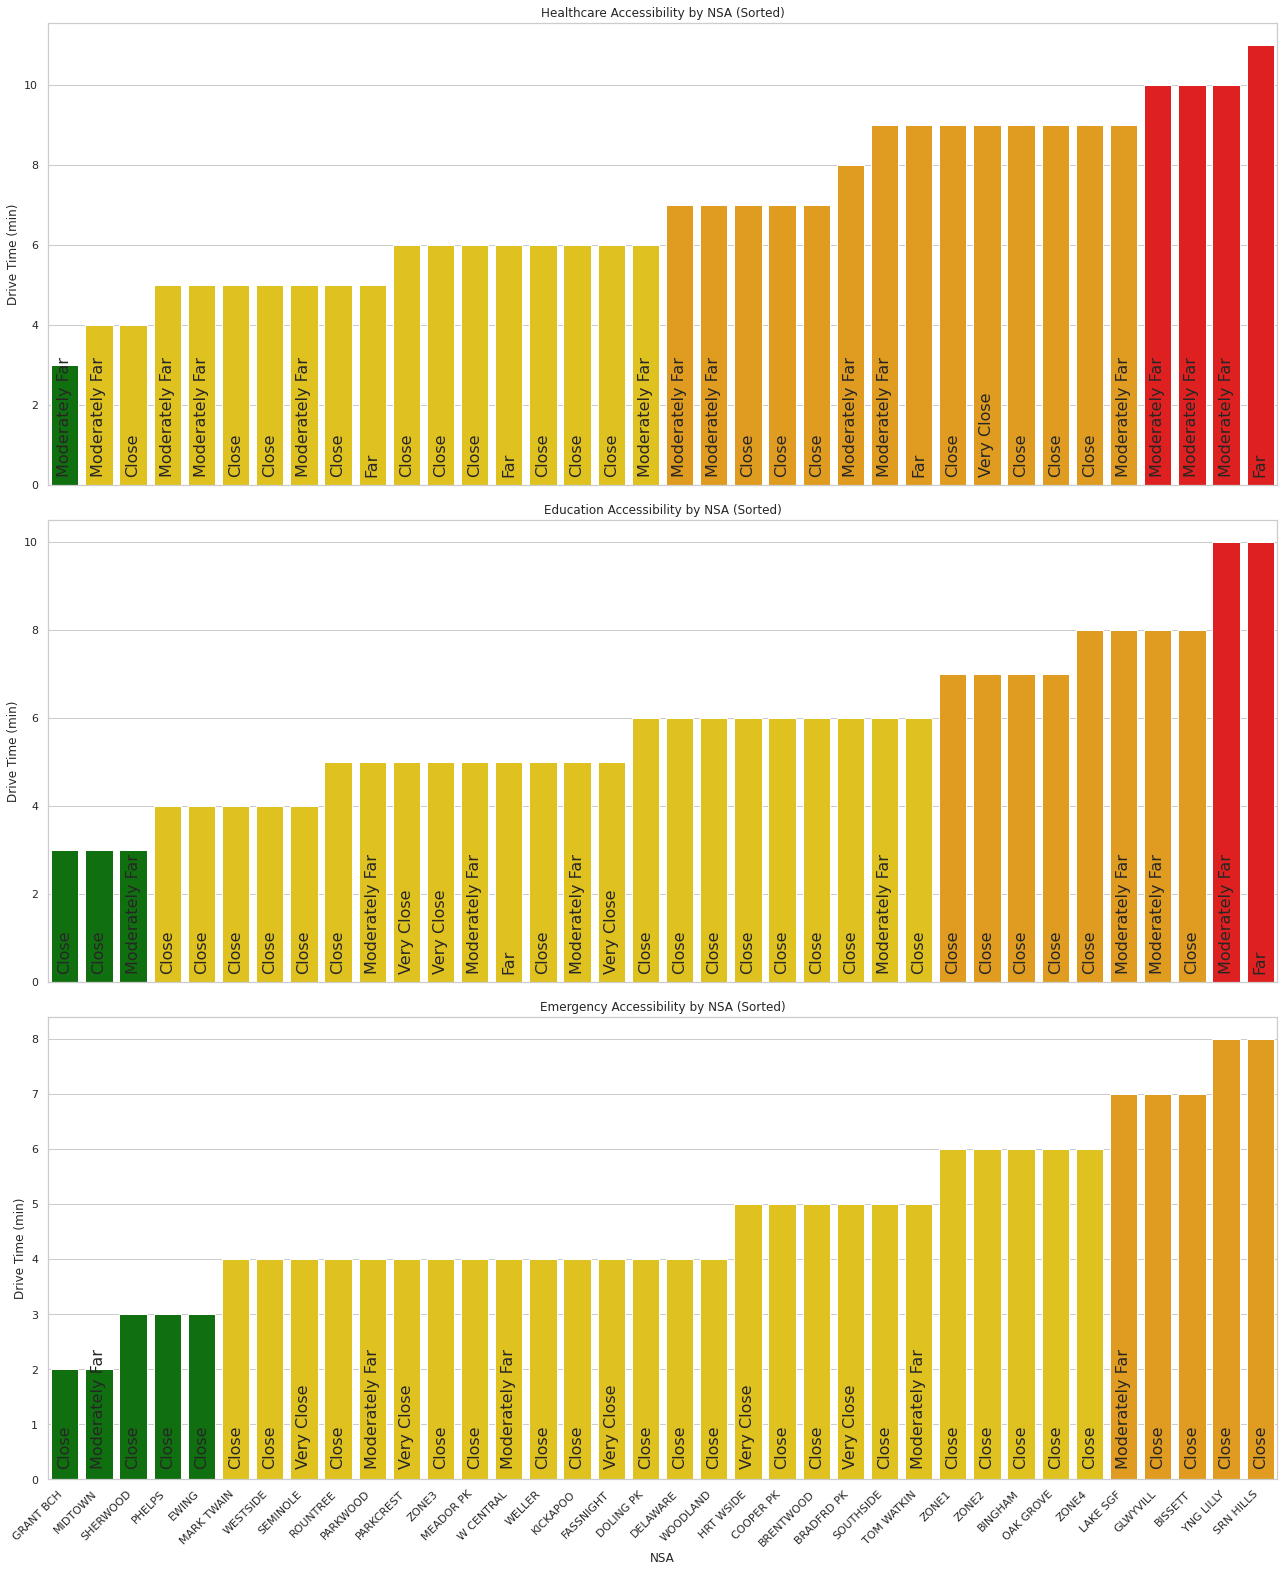

In [47]:
# Color mapping with emphasis on "Far"
highlight_color_map = {
    'Very Close': 'green',
    'Close': 'gold',
    'Moderately Far': 'orange',
    'Far': 'red'
}

# Assign colors
healthcare_colors = healthcare_sorted['Healthcare_Category'].map(highlight_color_map)
education_colors = education_sorted['Education_Category'].map(highlight_color_map)
emergency_colors = emergency_sorted['Emergency_Category'].map(highlight_color_map)

# Create multi-panel sorted bar chart
fig, axs = plt.subplots(3, 1, figsize=(18, 22), sharex=True)

# Healthcare chart
sns.barplot(data=healthcare_sorted, x='nsa', y='Healthcare_Index',
            palette=healthcare_colors, ax=axs[0])
axs[0].set_title("Healthcare Accessibility by NSA (Sorted)")
axs[0].set_ylabel("Drive Time (min)")
axs[0].set_xlabel("")
for index, row in healthcare_sorted.iterrows():
    axs[0].text(index, 0.2, row['Healthcare_Category'], ha='center', va='bottom', rotation=90, fontsize=16)

# Education chart
sns.barplot(data=education_sorted, x='nsa', y='Education_Index',
            palette=education_colors, ax=axs[1])
axs[1].set_title("Education Accessibility by NSA (Sorted)")
axs[1].set_ylabel("Drive Time (min)")
axs[1].set_xlabel("")
for index, row in education_sorted.iterrows():
    axs[1].text(index, 0.2, row['Education_Category'], ha='center', va='bottom', rotation=90, fontsize=16)

# Emergency chart
sns.barplot(data=emergency_sorted, x='nsa', y='Emergency_Index',
            palette=emergency_colors, ax=axs[2])
axs[2].set_title("Emergency Accessibility by NSA (Sorted)")
axs[2].set_ylabel("Drive Time (min)")
axs[2].set_xlabel("NSA")
for index, row in emergency_sorted.iterrows():
    axs[2].text(index, 0.2, row['Emergency_Category'], ha='center', va='bottom', rotation=90, fontsize=16)

# Format
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Healthcare Accessibility by NSA

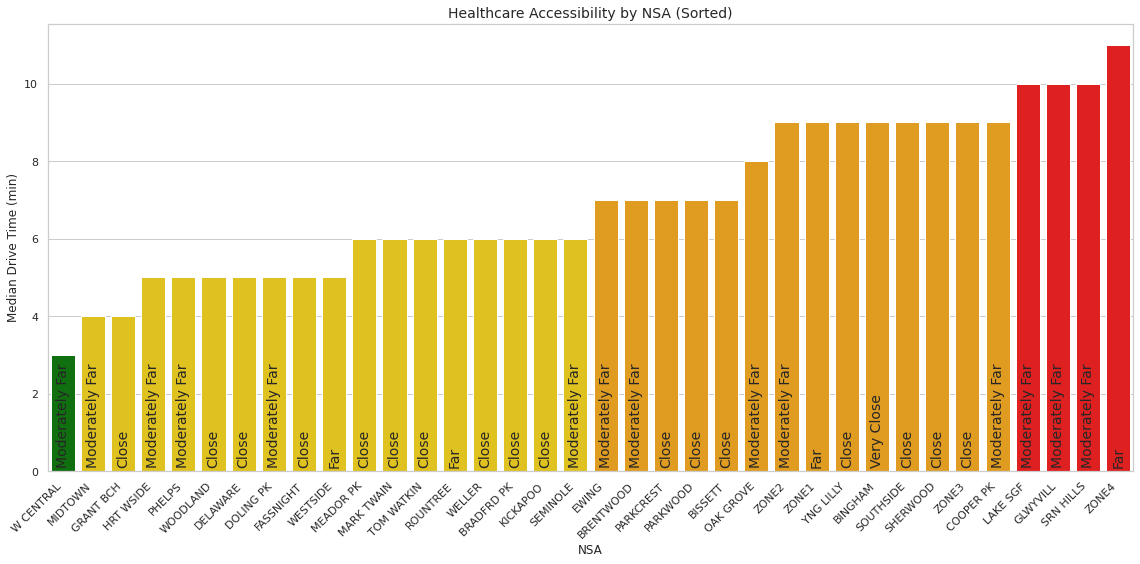

In [48]:
plt.figure(figsize=(16, 8))
colors = healthcare_sorted['Healthcare_Category'].map(highlight_color_map)

barplot = sns.barplot(
    data=healthcare_sorted,
    x='nsa',
    y='Healthcare_Index',
    palette=colors
)

plt.title("Healthcare Accessibility by NSA (Sorted)", fontsize=14)
plt.ylabel("Median Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Category labels only
for index, row in healthcare_sorted.iterrows():
    barplot.text(index, 0.1, row['Healthcare_Category'],
                 ha='center', va='bottom', rotation=90, fontsize=14)

plt.tight_layout()
plt.show()

### Education Accessibility by NSA

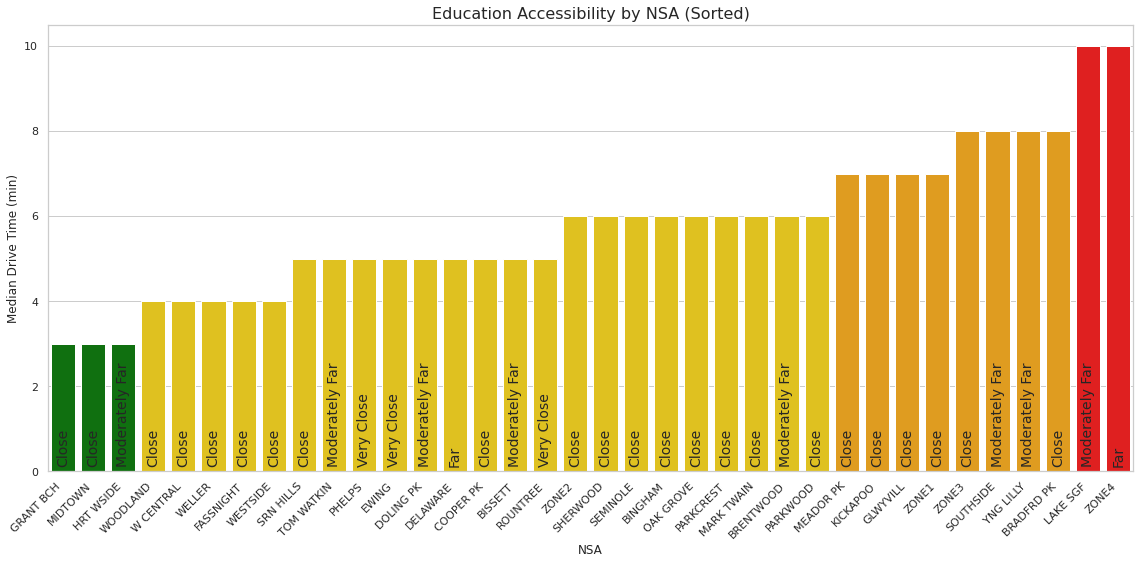

In [49]:
plt.figure(figsize=(16, 8))
colors = education_sorted['Education_Category'].map(highlight_color_map)

barplot = sns.barplot(
    data=education_sorted,
    x='nsa',
    y='Education_Index',
    palette=colors
)

plt.title("Education Accessibility by NSA (Sorted)", fontsize=16)
plt.ylabel("Median Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Category labels only
for index, row in education_sorted.iterrows():
    barplot.text(index, 0.1, row['Education_Category'],
                 ha='center', va='bottom', rotation=90, fontsize=14)

plt.tight_layout()
plt.show()

### Emergency Accessibility by NSA

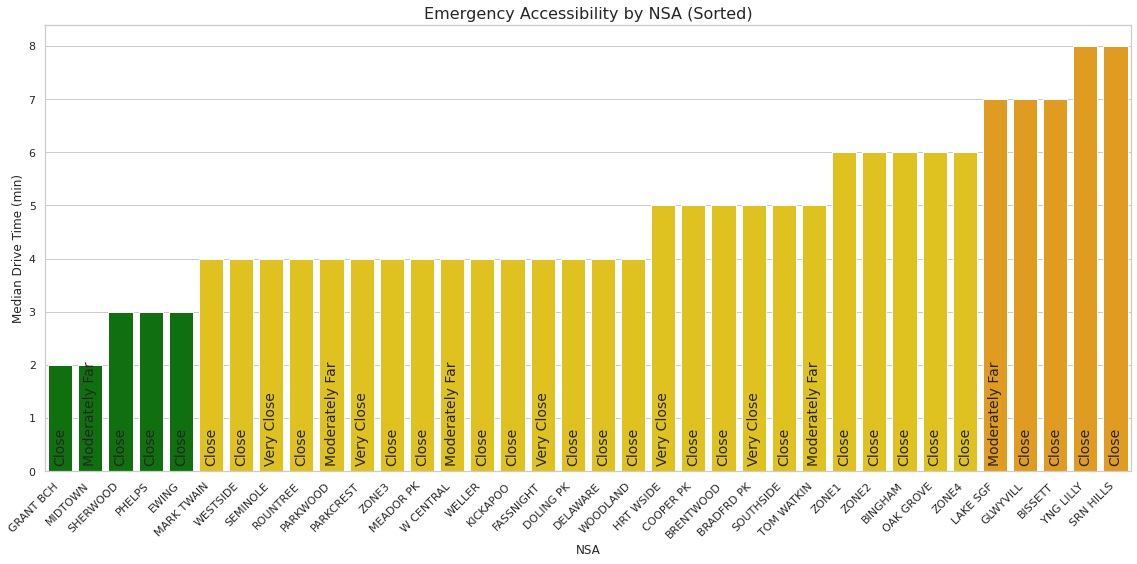

In [50]:
plt.figure(figsize=(16, 8))
colors = emergency_sorted['Emergency_Category'].map(highlight_color_map)

barplot = sns.barplot(
    data=emergency_sorted,
    x='nsa',
    y='Emergency_Index',
    palette=colors
)

plt.title("Emergency Accessibility by NSA (Sorted)", fontsize=16)
plt.ylabel("Median Drive Time (min)")
plt.xlabel("NSA")
plt.xticks(rotation=45, ha='right')

# Category labels only
for index, row in emergency_sorted.iterrows():
    barplot.text(index, 0.1, row['Emergency_Category'],
                 ha='center', va='bottom', rotation=90, fontsize=14)

plt.tight_layout()
plt.show()


## ANOVA and t-test

In [51]:
# Check for column name casing or trailing spaces
df.columns = df.columns.str.strip().str.lower()

# Confirm 'nsa' is present after standardization
assert 'nsa' in df.columns, "Column 'nsa' not found after standardizing"

# Re-define column names after standardization
healthcare_cols = ['drive_time_hospital', 'drive_time_nursing_home', 'drive_time_public_health']
education_cols = ['drive_time_early_childhood_school', 'drive_time_elementary_school',
                  'drive_time_middle_school', 'drive_time_high_school']
emergency_cols = ['drive_time_fire', 'drive_time_police']

# Group and calculate indexes
nsa_accessibility = df.groupby("nsa")[healthcare_cols + education_cols + emergency_cols].median()
nsa_accessibility['Healthcare_Index'] = nsa_accessibility[healthcare_cols].mean(axis=1).round()
nsa_accessibility['Education_Index'] = nsa_accessibility[education_cols].mean(axis=1).round()
nsa_accessibility['Emergency_Index'] = nsa_accessibility[emergency_cols].mean(axis=1).round()

# Build the final frame
categorized_access_custom = nsa_accessibility.reset_index()[['nsa', 'Healthcare_Index', 'Education_Index', 'Emergency_Index']]

categorized_access_custom.head()

,nsa,Healthcare_Index,Education_Index,Emergency_Index
0,BINGHAM,9.0,6.0,5.0
1,BISSETT,7.0,5.0,7.0
2,BRADFRD PK,7.0,8.0,5.0
3,BRENTWOOD,7.0,6.0,5.0
4,COOPER PK,9.0,5.0,5.0


In [52]:
import scipy.stats as stats
import pandas as pd

# Run ANOVA to compare Healthcare, Education, and Emergency accessibility across NSAs
anova_result = stats.f_oneway(
    categorized_access_custom['Healthcare_Index'].dropna(),
    categorized_access_custom['Education_Index'].dropna(),
    categorized_access_custom['Emergency_Index'].dropna()
)

# Run pairwise t-tests
ttest_health_edu = stats.ttest_rel(categorized_access_custom['Healthcare_Index'], categorized_access_custom['Education_Index'])
ttest_health_emergency = stats.ttest_rel(categorized_access_custom['Healthcare_Index'], categorized_access_custom['Emergency_Index'])
ttest_edu_emergency = stats.ttest_rel(categorized_access_custom['Education_Index'], categorized_access_custom['Emergency_Index'])

# Collect results
stats_summary = pd.DataFrame({
    "Comparison": [
        "ANOVA (Healthcare vs Education vs Emergency)",
        "Healthcare vs Education (paired t-test)",
        "Healthcare vs Emergency (paired t-test)",
        "Education vs Emergency (paired t-test)"
    ],
    "Statistic": [
        anova_result.statistic,
        ttest_health_edu.statistic,
        ttest_health_emergency.statistic,
        ttest_edu_emergency.statistic
    ],
    "p-value": [
        anova_result.pvalue,
        ttest_health_edu.pvalue,
        ttest_health_emergency.pvalue,
        ttest_edu_emergency.pvalue
    ]
})

stats_summary

,Comparison,Statistic,p-value
0,ANOVA (Healthcare vs Education vs Emergency),15.261142,1.520113e-06
1,Healthcare vs Education (paired t-test),5.009297,1.559855e-05
2,Healthcare vs Emergency (paired t-test),8.829187,1.984193e-10
3,Education vs Emergency (paired t-test),4.077346,2.494575e-04


### Tukey HSD Post-Hoc Test

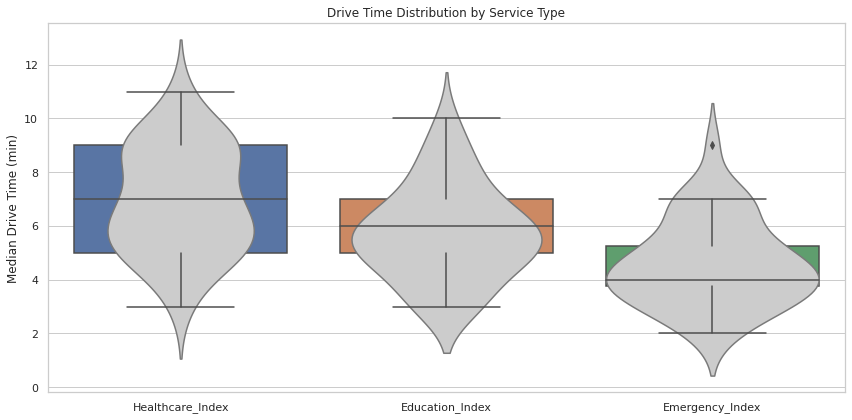

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Education_Index,Emergency_Index,-1.1389,0.0221,-2.1431,-0.1346,True
1,Education_Index,Healthcare_Index,1.1944,0.0154,0.1902,2.1987,True
2,Emergency_Index,Healthcare_Index,2.3333,0.0010,1.3291,3.3376,True


In [53]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the dataset into long format for Tukey HSD and plotting
melted_df = categorized_access_custom.melt(
    id_vars='nsa',
    value_vars=['Healthcare_Index', 'Education_Index', 'Emergency_Index'],
    var_name='Service',
    value_name='Drive_Time'
)

# Run Tukey's HSD post-hoc test
tukey_result = pairwise_tukeyhsd(endog=melted_df['Drive_Time'], groups=melted_df['Service'], alpha=0.05)
tukey_table = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

# Plot violin and boxplots
plt.figure(figsize=(12, 6))
sns.violinplot(data=melted_df, x='Service', y='Drive_Time', inner=None, color=".8")
sns.boxplot(data=melted_df, x='Service', y='Drive_Time')
plt.title("Drive Time Distribution by Service Type")
plt.ylabel("Median Drive Time (min)")
plt.xlabel("")
plt.tight_layout()
plt.show()

tukey_table

# Predictors of Poor Access (Linear Regression)

In [54]:
# Flag underserved based on drive times > 10 min
df['poor_health_access'] = df[['drive_time_hospital', 'drive_time_public_health', 'drive_time_nursing_home']].max(axis=1) > 10
df['poor_school_access'] = df[['drive_time_elementary_school', 'drive_time_middle_school', 'drive_time_high_school']].max(axis=1) > 10
df['poor_emergency_access'] = df[['drive_time_fire', 'drive_time_police']].max(axis=1) > 10

# Estimate affected populations
access_impact = {
    'Health': df.loc[df['poor_health_access'], 'total_population'].sum(),
    'Education': df.loc[df['poor_school_access'], 'total_population'].sum(),
    'Emergency': df.loc[df['poor_emergency_access'], 'total_population'].sum(),
    'All 3': df.loc[df['poor_health_access'] & df['poor_school_access'] & df['poor_emergency_access'], 'total_population'].sum()
}

# Create a prioritization score: total_population × average drive time
df['avg_drive_time'] = df[[
    'drive_time_hospital', 'drive_time_nursing_home', 'drive_time_public_health',
    'drive_time_elementary_school', 'drive_time_middle_school', 'drive_time_high_school',
    'drive_time_fire', 'drive_time_police'
]].mean(axis=1)

df['priority_score'] = df['total_population'] * df['avg_drive_time']

# Build regression model to predict avg drive time
from sklearn.linear_model import LinearRegression

# Drop rows with missing values in either predictors or target
regression_df = df[['total_population', 'median_income', 'avg_drive_time']].dropna()

# Define predictors (X) and outcome (y)
X = regression_df[['total_population', 'median_income']]
y = regression_df['avg_drive_time']

# Fit linear regression
reg = LinearRegression()
reg.fit(X, y)

# Create summary
regression_results = {
    'Intercept': reg.intercept_,
    'Coefficient: Total Population': reg.coef_[0],
    'Coefficient: Median Income': reg.coef_[1],
    'R-squared': reg.score(X, y)
}

regression_results

{'Intercept': 3.0531350913289312,
 'Coefficient: Total Population': 0.0008037592350807972,
 'Coefficient: Median Income': 2.661985772496156e-05,
 'R-squared': 0.24143434937547548}

<Figure size 864x432 with 0 Axes>

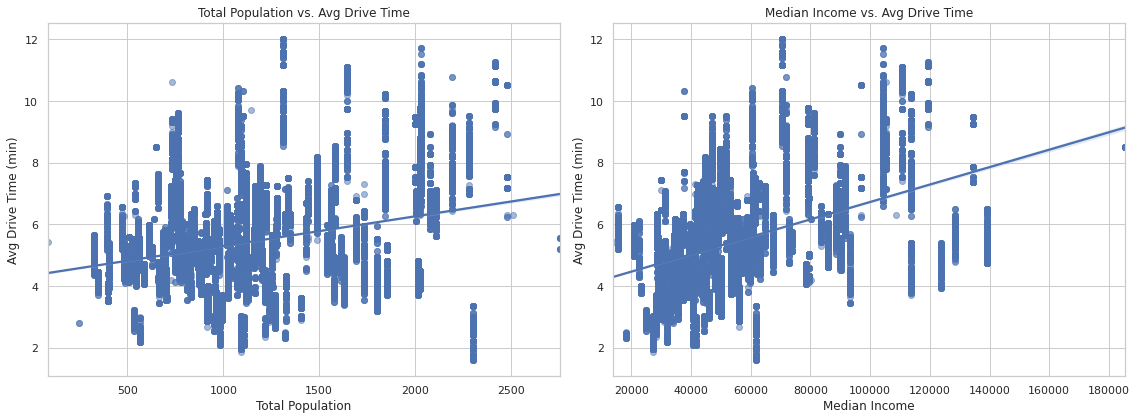

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the same filtered regression_df used for modeling
plt.figure(figsize=(12, 6))

# Scatter plot with regression line for each predictor
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Population vs. Drive Time
sns.regplot(data=regression_df, x='total_population', y='avg_drive_time', ax=axs[0], scatter_kws={'alpha':0.5})
axs[0].set_title('Total Population vs. Avg Drive Time')
axs[0].set_xlabel('Total Population')
axs[0].set_ylabel('Avg Drive Time (min)')

# Income vs. Drive Time
sns.regplot(data=regression_df, x='median_income', y='avg_drive_time', ax=axs[1], scatter_kws={'alpha':0.5})
axs[1].set_title('Median Income vs. Avg Drive Time')
axs[1].set_xlabel('Median Income')
axs[1].set_ylabel('Avg Drive Time (min)')

plt.tight_layout()
plt.show()

# Non Linear Models

## Decision Tree & Random Forest Results

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Use same clean dataset
X = regression_df[['total_population', 'median_income']]
y = regression_df['avg_drive_time']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train models
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
results = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest"],
    "R-squared": [r2_score(y_test, y_pred_dt), r2_score(y_test, y_pred_rf)],
    "RMSE": [mean_squared_error(y_test, y_pred_dt, squared=False),
             mean_squared_error(y_test, y_pred_rf, squared=False)]
})

results

,Model,R-squared,RMSE
0,Decision Tree,0.916575,0.485172
1,Random Forest,0.916601,0.485096


In [ ]:
mypasswd = getpass.getpass("Enter your database password: ")
username = 'jsmm8'
host = 'pgsql'
database = 'f24t03'

conn_string = f"postgresql+psycopg2://{username}:{mypasswd}@{host}/{database}"
engine = create_engine(conn_string)

Enter your database password: ········


In [ ]:
#Create the connection and extract data from 'race_data_processed' table
try:
    conn = psycopg2.connect(database=database,
                            user='jsmm8',
                            host='pgsql',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the springfield_neighborhood_service_areas table
query = "SELECT * FROM springfield_neighborhood_service_areas;"

try:
    nsa = gpd.read_postgis(query, conn, geom_col='geom')
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()

# Display the DataFrame
print(nsa.shape)
#sample 
nsa.head()

I am able to connect to the database
Data extracted successfully!
(38, 7)


,objectid_1,name,shapestare,shapestlen,shape_length,shape_area,geom
0,1,Grant Beach,3.107893e+07,22403.823703,6826.057182,2.885105e+06,"MULTIPOLYGON (((474089.118 4120469.519, 474088..."
1,2,Oak Grove,5.694040e+07,32119.505522,9786.311928,5.285924e+06,"MULTIPOLYGON (((480052.310 4114905.475, 480052..."
2,3,Midtown,2.839690e+07,21373.071458,6512.016504,2.636137e+06,"MULTIPOLYGON (((475419.924 4118741.896, 475052..."
3,4,Weller,2.558836e+07,20759.618765,6325.117077,2.375422e+06,"MULTIPOLYGON (((476778.203 4118815.866, 476776..."
4,5,Woodland Heights,2.922756e+07,23012.009407,7011.363483,2.713241e+06,"MULTIPOLYGON (((472934.565 4120381.619, 472883..."


In [59]:
# Export the NSA DataFrame to CSV (without geometry)
csv_path = "springfield_nsa_data.csv"

# Optionally convert geometry to WKT if you want to keep it:
# nsa['geometry'] = nsa['geom'].apply(lambda g: g.wkt)

# Export with geometry as WKT
nsa['geom'] = nsa['geom'].apply(lambda g: g.wkt)
nsa.to_csv("springfield_nsa_data_with_geom.csv", index=False)

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
